## Missing Value Clustering

This notebook aims to identify the patterns of missing value and cluster them together.

### Motivation

When analyzing data, some trends discoverd may be caused by missing value. This notebook aims to address those issue.

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.colors as colors
import pickle
import missingno as msno

## Worldbank Data

In [2]:
df = pd.read_csv('dataset/worldbank/API.csv')
meta_country = pd.read_csv('dataset/worldbank/Metadata_Country_API_19_DS2_en_csv_v2_3159902.csv')
meta_indicator = pd.read_csv('dataset/worldbank/Metadata_Indicator_API_19_DS2_en_csv_v2_3159902.csv')

### Preprocessing Data

Missing value: fill null value with 0, and fill not null value with 1 (only apply this method on year dimension)

In [3]:
# Get  columns whose data type is float

floatColumns = df.dtypes[df.dtypes == np.float]

# list of columns whose data type is float

listOfFloatColumnNames = list(floatColumns.index)

print(listOfFloatColumnNames)

['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']


In [4]:
# Get  columns whose data type is object

objectColumns = df.dtypes[df.dtypes == np.object]

# list of columns whose data type is object

listOfObjectColumnNames = list(objectColumns.index)

print(listOfObjectColumnNames)

['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']


In [5]:
# number of unique values for country and indicator

df[listOfObjectColumnNames].nunique()

Country Name      266
Country Code      266
Indicator Name     76
Indicator Code     76
dtype: int64

In [6]:
# How the original (not yet preprocessed data) looks like

df_years = df[listOfFloatColumnNames]
df_years.tail()

1960           1961           1962           1963           1964  \
20211   NaN            NaN            NaN            NaN            NaN   
20212   NaN            NaN            NaN            NaN            NaN   
20213   NaN       4.872690       5.001939       5.131188       5.260437   
20214   NaN      28.396019      28.615743      28.835466      29.055189   
20215   NaN  109850.000000  110700.000000  111550.000000  112400.000000   

                1965           1966           1967           1968  \
20211            NaN            NaN            NaN            NaN   
20212            NaN            NaN            NaN            NaN   
20213       5.337986       5.518935       5.648184       5.777433   
20214      29.223213      29.494636      29.714360      29.934083   
20215  113050.000000  114100.000000  114950.000000  115800.000000   

                1969  ...           2011           2012           2013  \
20211            NaN  ...            NaN            NaN            NaN   
20212            NaN  ...            NaN            NaN            NaN   
20213       5.906682  ...      10.856921      10.339925      10.339925   
20214      30.153806  ...      42.393693      41.876696      41.876696   
20215  116650.000000  ...  164000.000000  162000.000000  162000.000000   

                2014           2015           2016           2017  \
20211            NaN            NaN            NaN            NaN   
20212            NaN            NaN            NaN            NaN   
20213      10.339925      10.339925      10.339925      10.339925   
20214      41.876696      41.876696      41.876696      41.876696   
20215  162000.000000  162000.000000  162000.000000  162000.000000   

                2018  2019  2020  
20211            NaN   NaN   NaN  
20212            NaN   NaN   NaN  
20213      10.339925   NaN   NaN  
20214      41.876696   NaN   NaN  
20215  162000.000000   NaN   NaN  

[5 rows x 61 columns]

In [7]:
# fill nan with 0, and fill not nan with 1

df_years = df_years.fillna(0)
df_years[df_years[listOfFloatColumnNames] != 0] = 1
df_years = df_years.astype('int')
df_years.tail()

1960  1961  1962  1963  1964  1965  1966  1967  1968  1969  ...  2011  \
20211     0     0     0     0     0     0     0     0     0     0  ...     0   
20212     0     0     0     0     0     0     0     0     0     0  ...     0   
20213     0     1     1     1     1     1     1     1     1     1  ...     1   
20214     0     1     1     1     1     1     1     1     1     1  ...     1   
20215     0     1     1     1     1     1     1     1     1     1  ...     1   

       2012  2013  2014  2015  2016  2017  2018  2019  2020  
20211     0     0     0     0     0     0     0     0     0  
20212     0     0     0     0     0     0     0     0     0  
20213     1     1     1     1     1     1     1     0     0  
20214     1     1     1     1     1     1     1     0     0  
20215     1     1     1     1     1     1     1     0     0  

[5 rows x 61 columns]

In [8]:
df_years.apply(pd.Series.value_counts)

1960   1961   1962   1963   1964   1965   1966   1967   1968   1969  ...  \
0  17538  16126  15947  16081  16040  16001  15979  15807  15948  15932  ...   
1   2678   4090   4269   4135   4176   4215   4237   4409   4268   4284  ...   

    2011   2012   2013   2014   2015   2016   2017   2018   2019   2020  
0   9149   8669  10145  10153  10788  11447  12200  12843  16559  17747  
1  11067  11547  10071  10063   9428   8769   8016   7373   3657   2469  

[2 rows x 61 columns]

In [9]:
# Only indicator name is needed

df_indicator = df[listOfObjectColumnNames].iloc[: , 2:3]
df_indicator

Indicator Name
0               Urban population (% of total population)
1                                       Urban population
2                     Urban population growth (annual %)
3                                      Population, total
4                           Population growth (annual %)
...                                                  ...
20211  Rural land area where elevation is below 5 met...
20212  Rural land area where elevation is below 5 met...
20213                       Arable land (% of land area)
20214                 Agricultural land (% of land area)
20215                         Agricultural land (sq. km)

[20216 rows x 1 columns]

In [10]:
# concat df_indicator and df_years back together

df_indicatorAndYears = pd.concat([df_indicator, df_years], axis=1)

# final preprocessed data

df_indicatorAndYears.tail()

Indicator Name  1960  1961  1962  \
20211  Rural land area where elevation is below 5 met...     0     0     0   
20212  Rural land area where elevation is below 5 met...     0     0     0   
20213                       Arable land (% of land area)     0     1     1   
20214                 Agricultural land (% of land area)     0     1     1   
20215                         Agricultural land (sq. km)     0     1     1   

       1963  1964  1965  1966  1967  1968  ...  2011  2012  2013  2014  2015  \
20211     0     0     0     0     0     0  ...     0     0     0     0     0   
20212     0     0     0     0     0     0  ...     0     0     0     0     0   
20213     1     1     1     1     1     1  ...     1     1     1     1     1   
20214     1     1     1     1     1     1  ...     1     1     1     1     1   
20215     1     1     1     1     1     1  ...     1     1     1     1     1   

       2016  2017  2018  2019  2020  
20211     0     0     0     0     0  
20212     0     0     0     0     0  
20213     1     1     1     0     0  
20214     1     1     1     0     0  
20215     1     1     1     0     0  

[5 rows x 62 columns]

## Group by Indicator

There are a few ways of checking the pattern of missing value. This section start off with missing value group by indicator, which means all country's data will be grouped (sum) together in each of the 76 indicators.

In [11]:
# Make a new copy
df_groupBy_indicatorCode = df_indicatorAndYears

# Then group by indicator
df_groupBy_indicatorCode = df_groupBy_indicatorCode.groupby(['Indicator Name']).sum()
df_groupBy_indicatorCode.tail()

1960  1961  1962  1963  \
Indicator Name                                                               
Urban land area where elevation is below 5 mete...     0     0     0     0   
Urban population                                     262   262   262   262   
Urban population (% of total population)             263   263   263   263   
Urban population growth (annual %)                     1   262   262   262   
Urban population living in areas where elevatio...     0     0     0     0   

                                                    1964  1965  1966  1967  \
Indicator Name                                                               
Urban land area where elevation is below 5 mete...     0     0     0     0   
Urban population                                     262   262   262   262   
Urban population (% of total population)             263   263   263   263   
Urban population growth (annual %)                   262   262   262   262   
Urban population living in areas where elevatio...     0     0     0     0   

                                                    1968  1969  ...  2011  \
Indicator Name                                                  ...         
Urban land area where elevation is below 5 mete...     0     0  ...     0   
Urban population                                     262   262  ...   263   
Urban population (% of total population)             263   263  ...   263   
Urban population growth (annual %)                   262   262  ...   263   
Urban population living in areas where elevatio...     0     0  ...     0   

                                                    2012  2013  2014  2015  \
Indicator Name                                                               
Urban land area where elevation is below 5 mete...     0     0     0     0   
Urban population                                     262   262   262   262   
Urban population (% of total population)             262   262   262   262   
Urban population growth (annual %)                   262   262   262   262   
Urban population living in areas where elevatio...     0     0     0     0   

                                                    2016  2017  2018  2019  \
Indicator Name                                                               
Urban land area where elevation is below 5 mete...     0     0     0     0   
Urban population                                     262   262   262   262   
Urban population (% of total population)             262   262   262   262   
Urban population growth (annual %)                   262   262   262   262   
Urban population living in areas where elevatio...     0     0     0     0   

                                                    2020  
Indicator Name                                            
Urban land area where elevation is below 5 mete...     0  
Urban population                                     262  
Urban population (% of total population)             262  
Urban population growth (annual %)                   262  
Urban population living in areas where elevatio...     0  

[5 rows x 61 columns]

In [12]:
# drop index column first
df_check = df_groupBy_indicatorCode.reset_index(drop=True)

# check value_counts() for all columns (should get only 0 - 266 )
df_check.apply(pd.Series.value_counts)

1960  1961  1962  1963  1964  1965  1966  1967  1968  1969  ...  2011  \
0    49.0  45.0  42.0  45.0  45.0  45.0  45.0  41.0  45.0  44.0  ...  20.0   
1     2.0   NaN   2.0   NaN   NaN   NaN   NaN   1.0   NaN   1.0  ...   NaN   
2     NaN   NaN   NaN   NaN   NaN   NaN   NaN   2.0   NaN   NaN  ...   NaN   
3     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
4     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
259   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
262   1.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0  ...   NaN   
263   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   3.0   
264   1.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0  ...   1.0   
265   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   2.0   

     2012  2013  2014  2015  2016  2017  2018  2019  2020  
0    18.0  25.0  23.0  25.0  32.0  37.0  40.0  56.0  63.0  
1     NaN   NaN   1.0   1.0   2.0   2.0   2.0   2.0   NaN  
2     NaN   NaN   1.0   NaN   NaN   NaN   NaN   NaN   NaN  
3     NaN   NaN   1.0   1.0   NaN   NaN   NaN   NaN   NaN  
4     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...  
259   NaN   NaN   NaN   NaN   1.0   1.0   1.0   NaN   NaN  
262   3.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0  
263   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
264   3.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0   2.0  
265   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[259 rows x 61 columns]

#### Simple EDA for missing value

<AxesSubplot:>

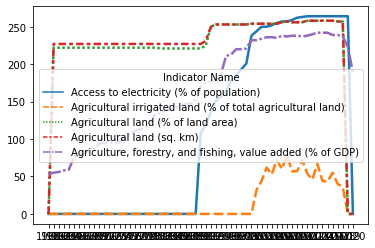

In [13]:
# The first and second indicator has similar missing value pattern

df_temp = (df_groupBy_indicatorCode.iloc[0:5 , :]).transpose()

sns.lineplot(data=df_temp, palette="tab10", linewidth=2.5)

<AxesSubplot:>

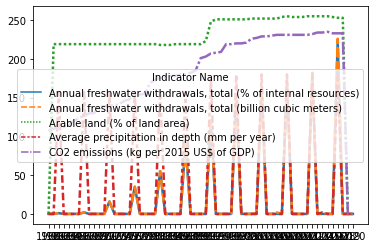

In [14]:
# This is another missing value pattern found

df_temp = (df_groupBy_indicatorCode.iloc[5:10 , :]).transpose()

sns.lineplot(data=df_temp, palette="tab10", linewidth=2.5)

<AxesSubplot:>

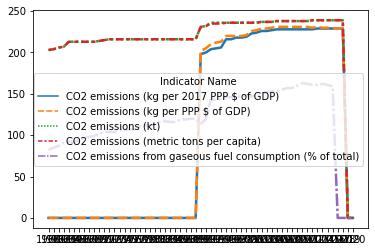

In [15]:
# more of them

df_temp = (df_groupBy_indicatorCode.iloc[10:15 , :]).transpose()

sns.lineplot(data=df_temp, palette="tab10", linewidth=2.5)

## Time series clustering based on indicator

Since there are 76 different indicators and all of them may have different pattern of missing value. This section aim to use time series clustering to group all missing data value pattern into their respective category.

The resource of tslearn can be obtained from [tslearn documentation](https://tslearn.readthedocs.io/en/stable/auto_examples/clustering/plot_kmeans.html#sphx-glr-auto-examples-clustering-plot-kmeans-py).

In [16]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset

# Matplotlib customization
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.dpi'] = 150.
mpl.rcParams["figure.figsize"] = (20,50)

In [17]:
# copy the data
df_groupBy_indicatorCode_normalized = df_groupBy_indicatorCode.copy()
  
# apply normalization techniques
for column in df_groupBy_indicatorCode_normalized.columns:
    # max scaled normalization
    df_groupBy_indicatorCode_normalized[column] = df_groupBy_indicatorCode_normalized[column]  / 266 
      
# view normalized data
df_groupBy_indicatorCode_normalized.tail()

1960      1961  \
Indicator Name                                                           
Urban land area where elevation is below 5 mete...  0.000000  0.000000   
Urban population                                    0.984962  0.984962   
Urban population (% of total population)            0.988722  0.988722   
Urban population growth (annual %)                  0.003759  0.984962   
Urban population living in areas where elevatio...  0.000000  0.000000   

                                                        1962      1963  \
Indicator Name                                                           
Urban land area where elevation is below 5 mete...  0.000000  0.000000   
Urban population                                    0.984962  0.984962   
Urban population (% of total population)            0.988722  0.988722   
Urban population growth (annual %)                  0.984962  0.984962   
Urban population living in areas where elevatio...  0.000000  0.000000   

                                                        1964      1965  \
Indicator Name                                                           
Urban land area where elevation is below 5 mete...  0.000000  0.000000   
Urban population                                    0.984962  0.984962   
Urban population (% of total population)            0.988722  0.988722   
Urban population growth (annual %)                  0.984962  0.984962   
Urban population living in areas where elevatio...  0.000000  0.000000   

                                                        1966      1967  \
Indicator Name                                                           
Urban land area where elevation is below 5 mete...  0.000000  0.000000   
Urban population                                    0.984962  0.984962   
Urban population (% of total population)            0.988722  0.988722   
Urban population growth (annual %)                  0.984962  0.984962   
Urban population living in areas where elevatio...  0.000000  0.000000   

                                                        1968      1969  ...  \
Indicator Name                                                          ...   
Urban land area where elevation is below 5 mete...  0.000000  0.000000  ...   
Urban population                                    0.984962  0.984962  ...   
Urban population (% of total population)            0.988722  0.988722  ...   
Urban population growth (annual %)                  0.984962  0.984962  ...   
Urban population living in areas where elevatio...  0.000000  0.000000  ...   

                                                        2011      2012  \
Indicator Name                                                           
Urban land area where elevation is below 5 mete...  0.000000  0.000000   
Urban population                                    0.988722  0.984962   
Urban population (% of total population)            0.988722  0.984962   
Urban population growth (annual %)                  0.988722  0.984962   
Urban population living in areas where elevatio...  0.000000  0.000000   

                                                        2013      2014  \
Indicator Name                                                           
Urban land area where elevation is below 5 mete...  0.000000  0.000000   
Urban population                                    0.984962  0.984962   
Urban population (% of total population)            0.984962  0.984962   
Urban population growth (annual %)                  0.984962  0.984962   
Urban population living in areas where elevatio...  0.000000  0.000000   

                                                        2015      2016  \
Indicator Name                                                           
Urban land area where elevation is below 5 mete...  0.000000  0.000000   
Urban population                                    0.984962  0.984962   
Urban population (% of total population)            0.984962  0.984962   
Urban population g

### Parameters

In [18]:
seed = 1
np.random.seed(seed)

In [19]:
# Set number of cluster

cluster_number = 20

In [20]:
# training set (there's no testing set)

X_train_indicatorCode = to_time_series_dataset(df_groupBy_indicatorCode_normalized.copy())

### Functions

In [21]:
def euclideanKMeans(cluster, seed, X_train):
    print("Euclidean k-means")
    km = TimeSeriesKMeans(n_clusters=cluster, 
                          verbose=True, 
                          random_state=seed, 
                          max_iter=10)
    y_pred = km.fit_predict(X_train)
#     clusters = pd.Series(data=y_pred, index=X_train.index)
#     clusters

    plt.figure()
    for yi in range(cluster):
        plt.subplot(cluster, 1, yi+1)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(km.cluster_centers_[yi].ravel(), "r-")
        plt.ylim(0, 1)
        plt.text(0.01, 0.50,'Cluster %d' % (yi + 1),
                 transform=plt.gca().transAxes)

    print("Euclidean k-means Chart")
    plt.show()
    return y_pred

In [22]:
# DBA-k-means
def dbaKMeans(cluster, seed, X_train):
    print("DBA k-means")
    dba_km = TimeSeriesKMeans(n_clusters=cluster,
                              n_init=2,
                              metric="dtw",
                              verbose=True,
                              max_iter_barycenter=10,
                              random_state=seed)
    y_pred = dba_km.fit_predict(X_train)

    for yi in range(cluster):
        plt.subplot(cluster, 1, yi+1)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
        plt.ylim(0, 1)
        plt.text(0.01, 0.50,'Cluster %d' % (yi + 1),
                 transform=plt.gca().transAxes)


    print("DBA k-means Chart")
    plt.show()
    return y_pred

In [23]:
# Soft-DTW-k-means
def softDTWKmean(cluster, seed, X_train):
    print("Soft-DTW k-means")
    sdtw_km = TimeSeriesKMeans(n_clusters=cluster,
                               metric="softdtw",
                               metric_params={"gamma": .01},
                               verbose=True,
                               random_state=seed)
    y_pred = sdtw_km.fit_predict(X_train)

    for yi in range(cluster):
        plt.subplot(cluster, 1, yi+1)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
        plt.ylim(0, 1)
        plt.text(0.01, 0.50,'Cluster %d' % (yi),
                 transform=plt.gca().transAxes)

    print("Soft-DTW k-means Chart")
    plt.show()
    return y_pred

In [51]:
def mergeClusterNames(y_pred, df_index):
    clusters = pd.Series(data=y_pred, index=df_index.index)
    df_cluster = clusters.to_frame()
    df_cluster.columns = ['cluster']
    return df_cluster

def getSingleCluster(df_cluster, n):
    # cluster 1 in the chart represent cluster 0 in the data.
    return df_cluster[df_cluster['cluster'] == n-1]

### Analysis

<span style="color:red">REMINDER:</span> **cluster 1 in the chart represents cluster 0 in data variable**

Euclidean k-means
0.351 --> 0.212 --> 0.204 --> 0.204 --> 
Euclidean k-means Chart


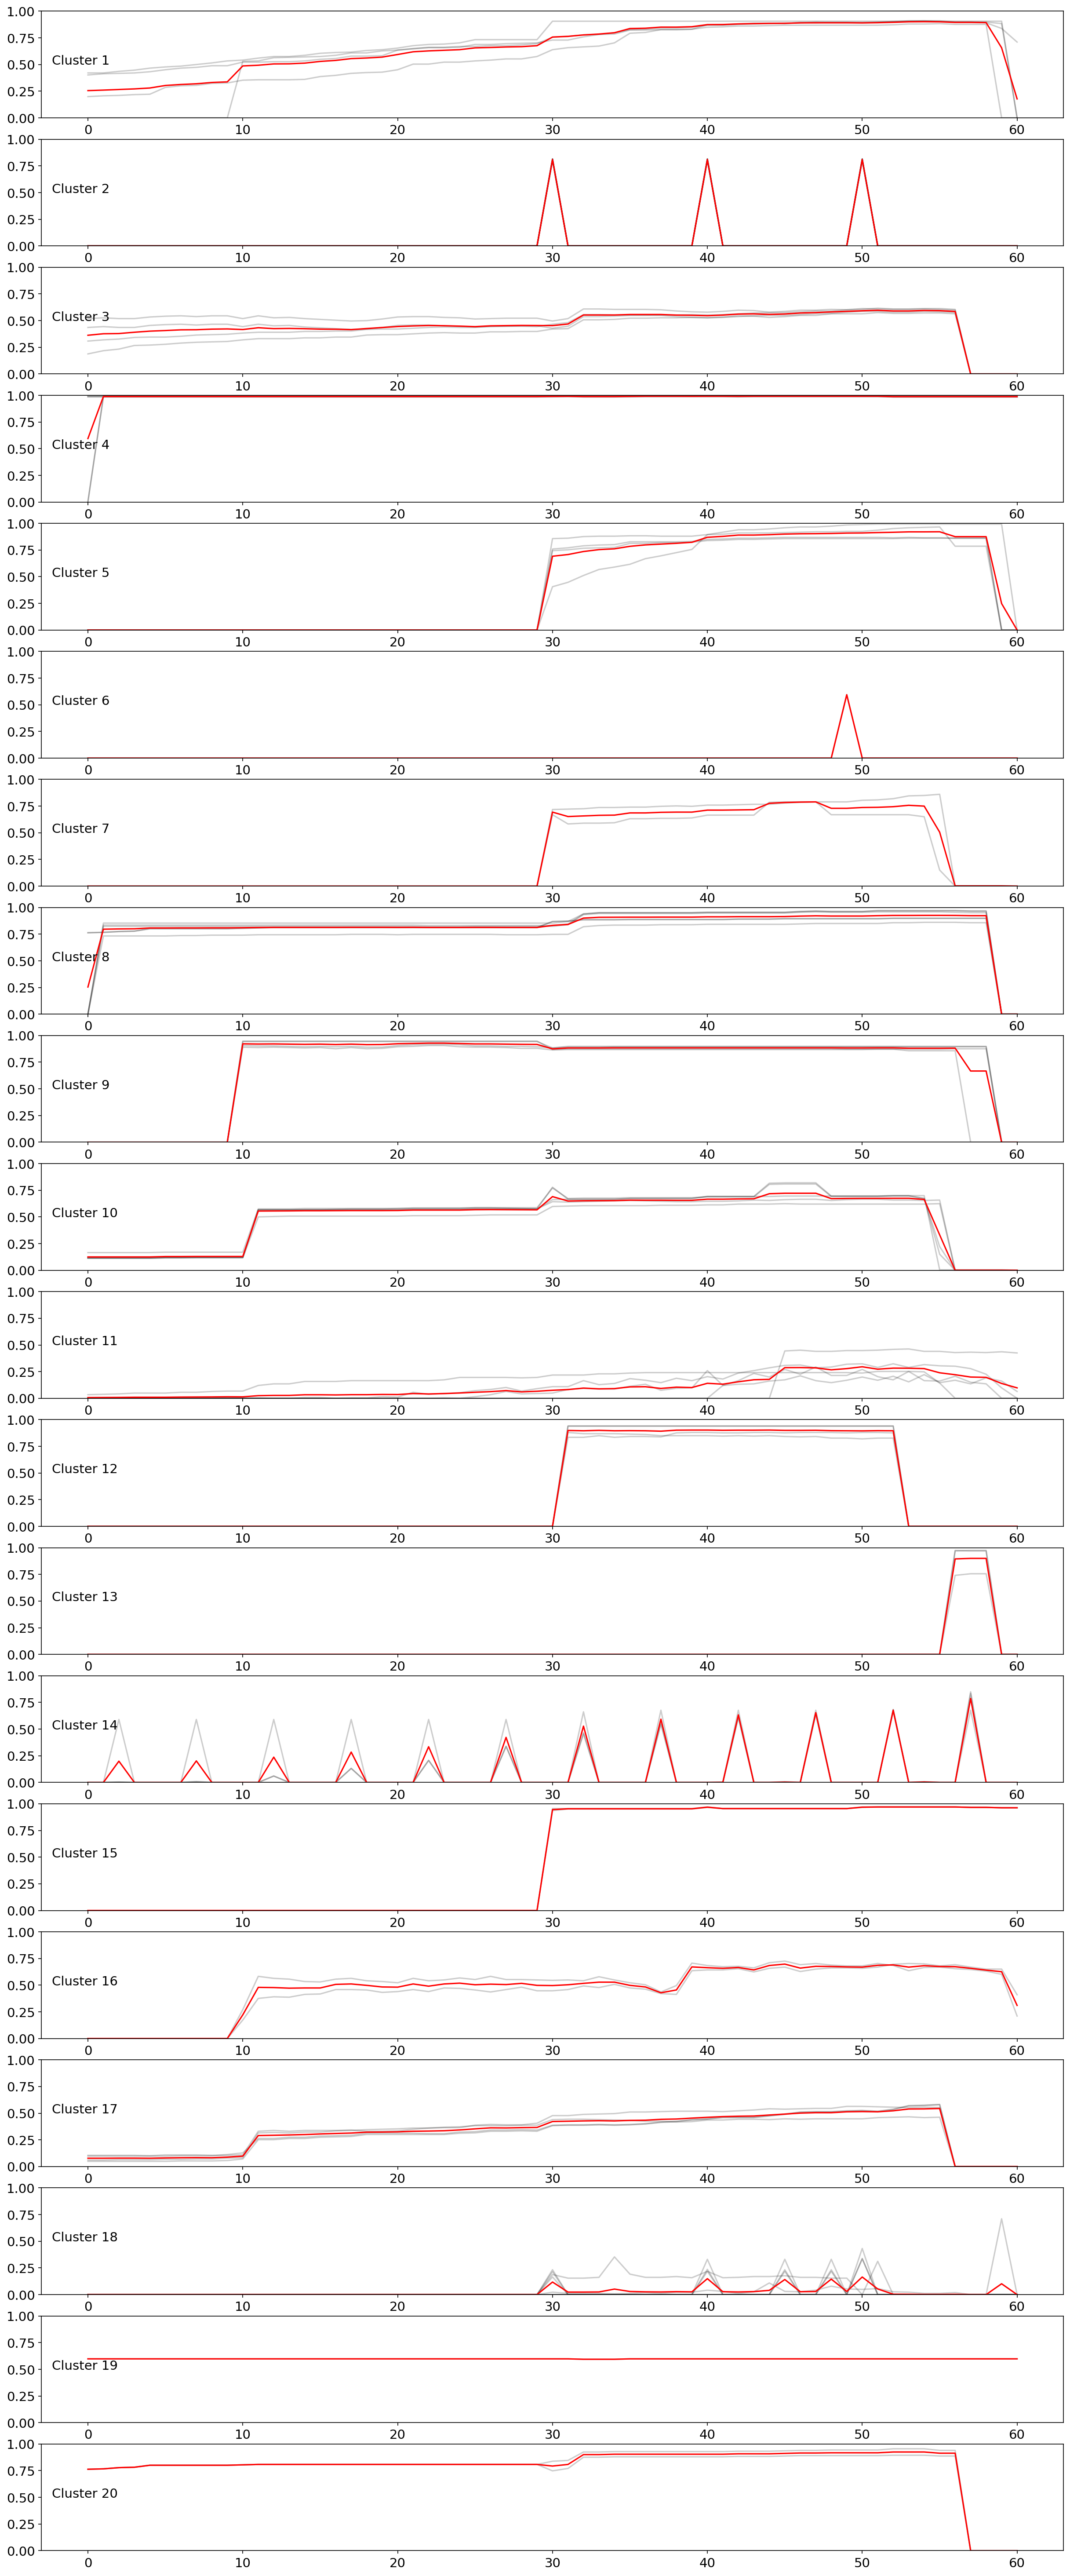

In [25]:
y_pred_Indicator_euclideanKM = euclideanKMeans(cluster_number, seed, X_train_indicatorCode)

In [26]:
print(y_pred_Indicator_euclideanKM)

[ 4 10  7  7  0 13 13  7 13  0  4  4  7  7  2  2 19 19  2  2  9 10  7 17
 17  5 17  9 16  9 16 10  9 16 16  9  6  0 14 14 17 17  1 12 11  8  0 11
  8 11  8 17  3 18  1  3 10 10 15  6  4  1  1  1 17 15 12 12 11  8  1  1
  3  3  3  1]


In [27]:
cluster_Indicator_euclideanKM = mergeClusterNames(y_pred_Indicator_euclideanKM, df_groupBy_indicatorCode)
getSingleCluster(cluster_Indicator_euclideanKM, 2)

cluster
Indicator Name                                             
Land area where elevation is below 5 meters (% ...        1
Population living in areas where elevation is b...        1
Rural land area where elevation is below 5 mete...        1
Rural land area where elevation is below 5 mete...        1
Rural population living in areas where elevatio...        1
Urban land area where elevation is below 5 mete...        1
Urban land area where elevation is below 5 mete...        1
Urban population living in areas where elevatio...        1

DBA k-means
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 304 out of 304 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 304 out of 304 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 304 out of 304 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 304 out of 304 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 304 out of 304 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.078 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1520 out of 1520 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.042 --> 

[Parallel(n_jobs=1)]: Done 1520 out of 1520 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.041 --> 

[Parallel(n_jobs=1)]: Done 1520 out of 1520 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.041 --> 
Init 2


[Parallel(n_jobs=1)]: Done 304 out of 304 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 304 out of 304 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 304 out of 304 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 304 out of 304 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 304 out of 304 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 304 out of 304 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 304 out of 304 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

0.073 --> 

[Parallel(n_jobs=1)]: Done 1520 out of 1520 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.031 --> 

[Parallel(n_jobs=1)]: Done 1520 out of 1520 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.028 --> 

[Parallel(n_jobs=1)]: Done 1520 out of 1520 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.028 --> 

[Parallel(n_jobs=1)]: Done 1520 out of 1520 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.028 --> 


[Parallel(n_jobs=1)]: Done 1520 out of 1520 | elapsed:    0.2s finished


DBA k-means Chart


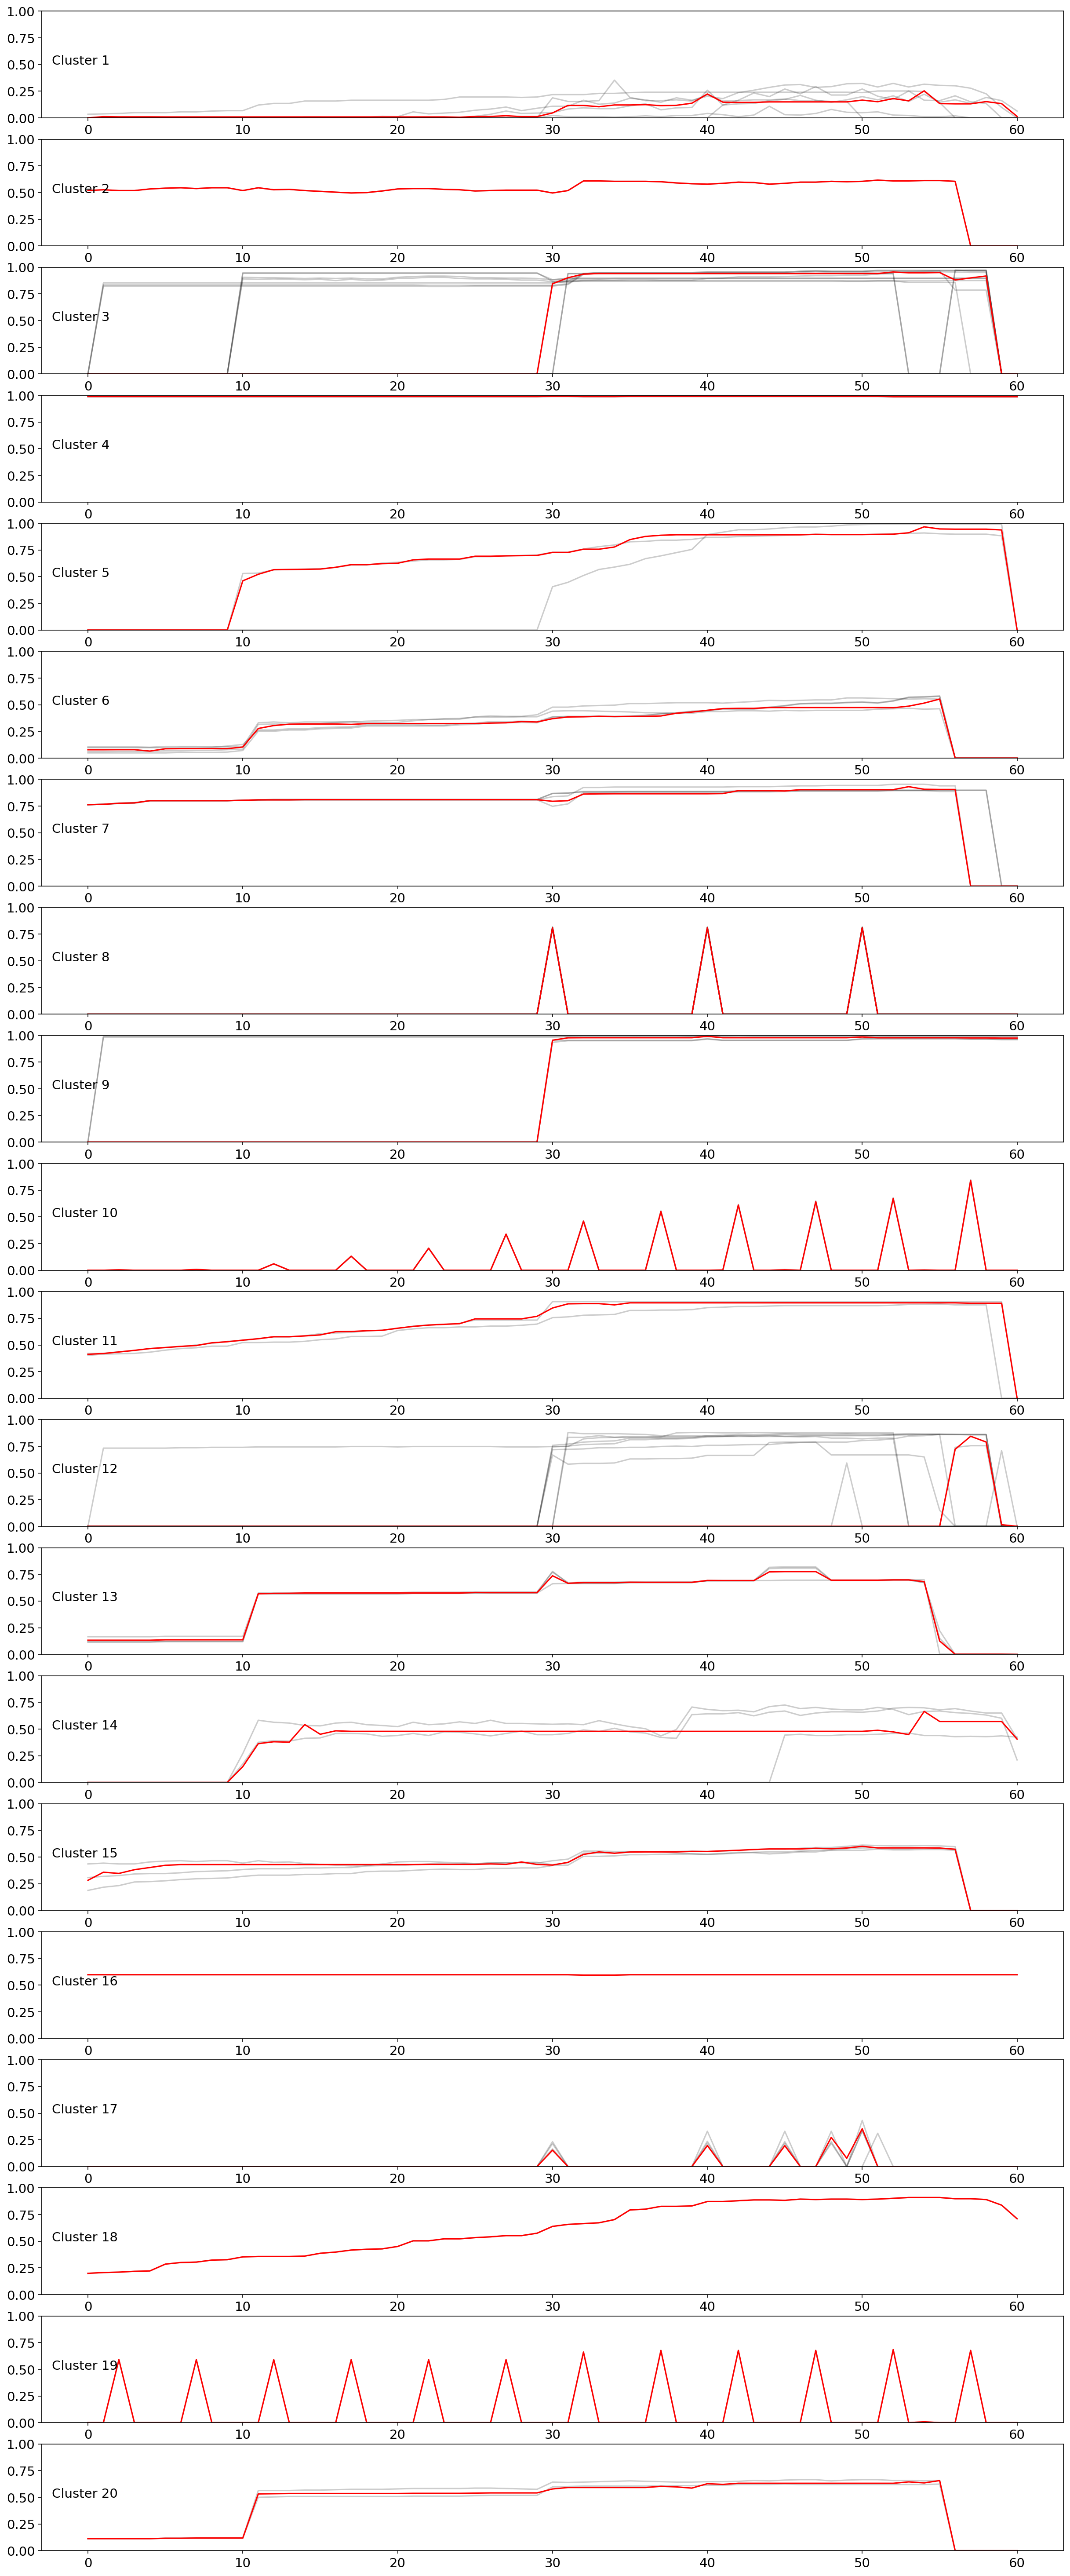

In [28]:
y_pred_Indicator_dbaKM = dbaKMeans(cluster_number, seed, X_train_indicatorCode)

In [29]:
print(y_pred_Indicator_dbaKM)

[ 4  0  2  2 17  9  9  2 18 10 11 11  6  6 14 14  6  6  1 14 12 13 11  0
 16 11 11 12  5 19  5  0 19  5  5 12 11  4  8  8  0 16  7 11  2  2 10  2
  2 11  2 16  8 15  7  3  0  0 13 11  2  7  7  7 16 13  2  2 11  2  7  7
  3  3  8  7]


In [73]:
cluster_Indicator_dbaKM = mergeClusterNames(y_pred_Indicator_dbaKM, df_groupBy_indicatorCode)

cluster
Indicator Name                                             
Annual freshwater withdrawals, total (% of inte...        9
Annual freshwater withdrawals, total (billion c...        9

In [83]:
# get the low data cluster's index

low_data_indicator1 = getSingleCluster(cluster_Indicator_dbaKM, 1)
low_data_indicator2 = getSingleCluster(cluster_Indicator_dbaKM, 8)
low_data_indicator3 = getSingleCluster(cluster_Indicator_dbaKM, 17)

cluster
Indicator Name                                             
Agricultural irrigated land (% of total agricul...        0
Community health workers (per 1,000 people)               0
Electricity production from nuclear sources (% ...        0
GHG net emissions/removals by LUCF (Mt of CO2 e...        0
Poverty headcount ratio at $1.90 a day (2011 PP...        0
Prevalence of underweight, weight for age (% of...        0

<AxesSubplot:>

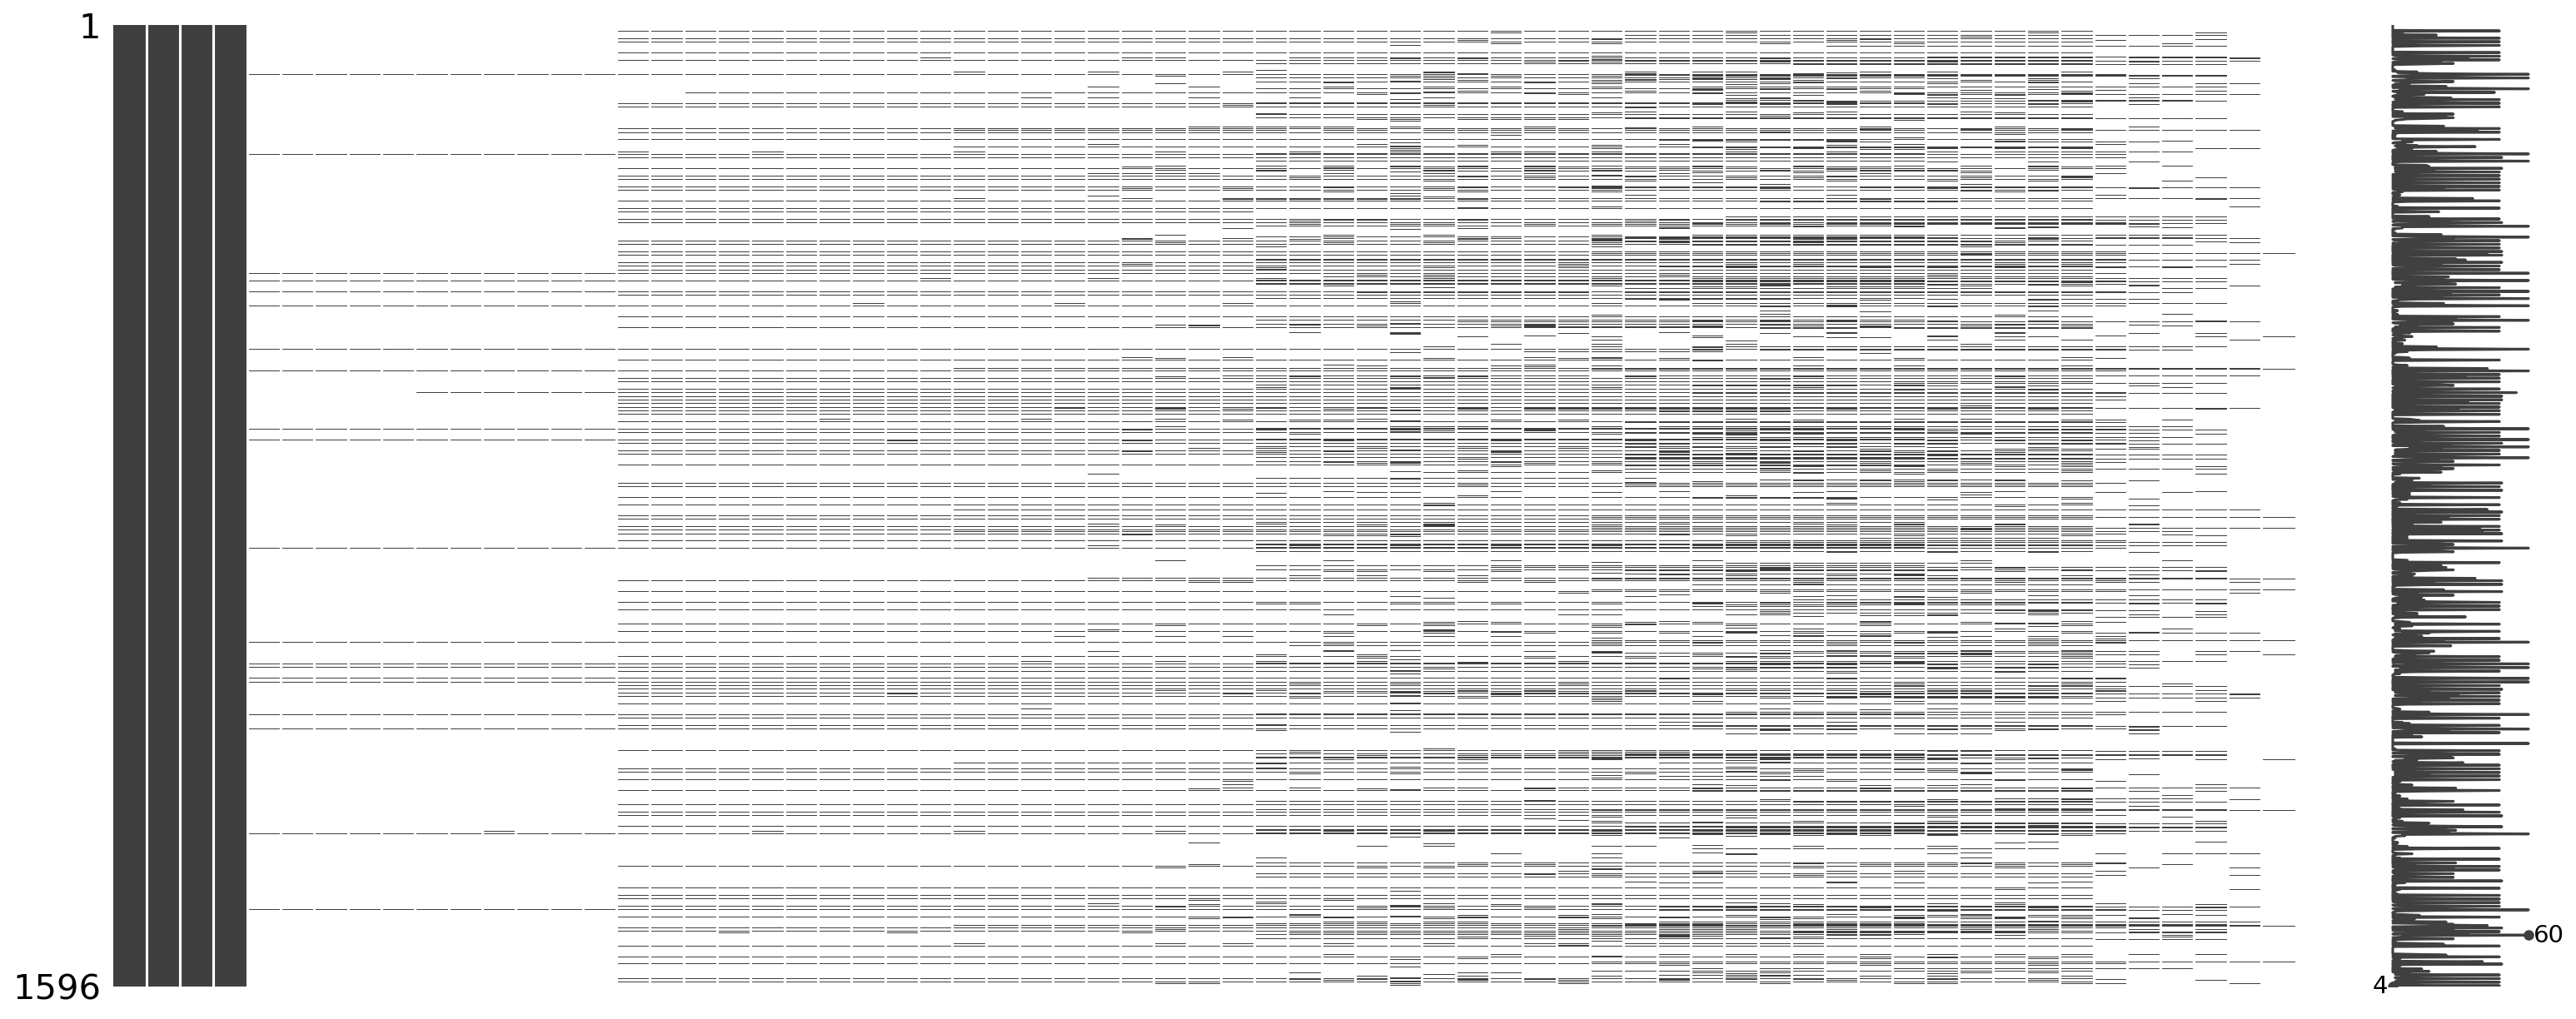

In [85]:
display(low_data_indicator1)
msno.matrix(df.loc[df['Indicator Name'].isin(low_data_indicator1.index.tolist())])

cluster
Indicator Name                                             
Land area where elevation is below 5 meters (% ...        7
Population living in areas where elevation is b...        7
Rural land area where elevation is below 5 mete...        7
Rural land area where elevation is below 5 mete...        7
Rural population living in areas where elevatio...        7
Urban land area where elevation is below 5 mete...        7
Urban land area where elevation is below 5 mete...        7
Urban population living in areas where elevatio...        7

<AxesSubplot:>

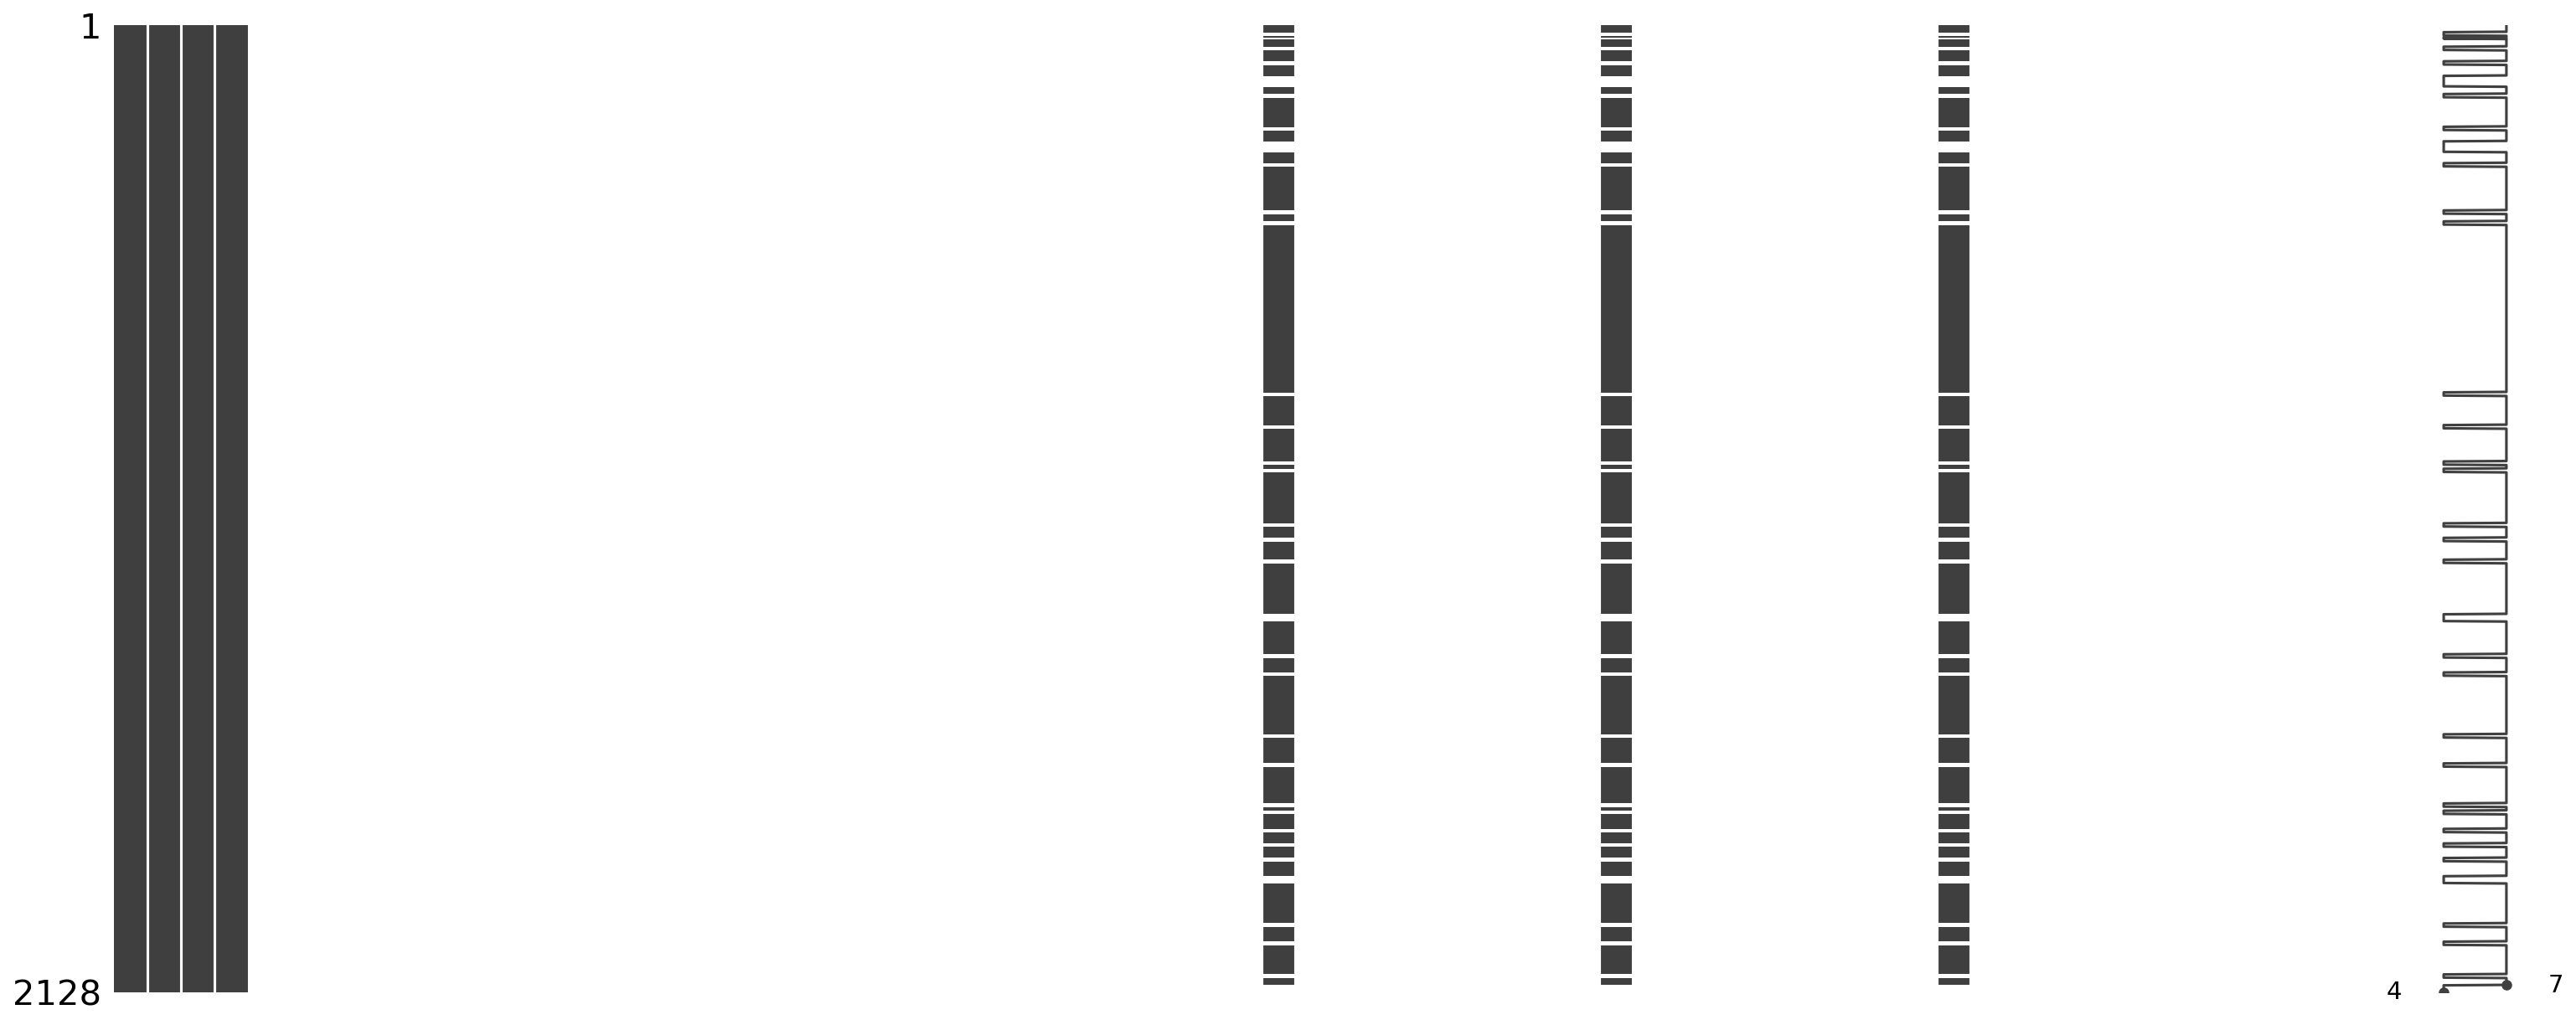

In [87]:
display(low_data_indicator2)
msno.matrix(df.loc[df['Indicator Name'].isin(low_data_indicator2.index.tolist())])

cluster
Indicator Name                                             
Disaster risk reduction progress score (1-5 sca...       16
HFC gas emissions (thousand metric tons of CO2 ...       16
PFC gas emissions (thousand metric tons of CO2 ...       16
SF6 gas emissions (thousand metric tons of CO2 ...       16

<AxesSubplot:>

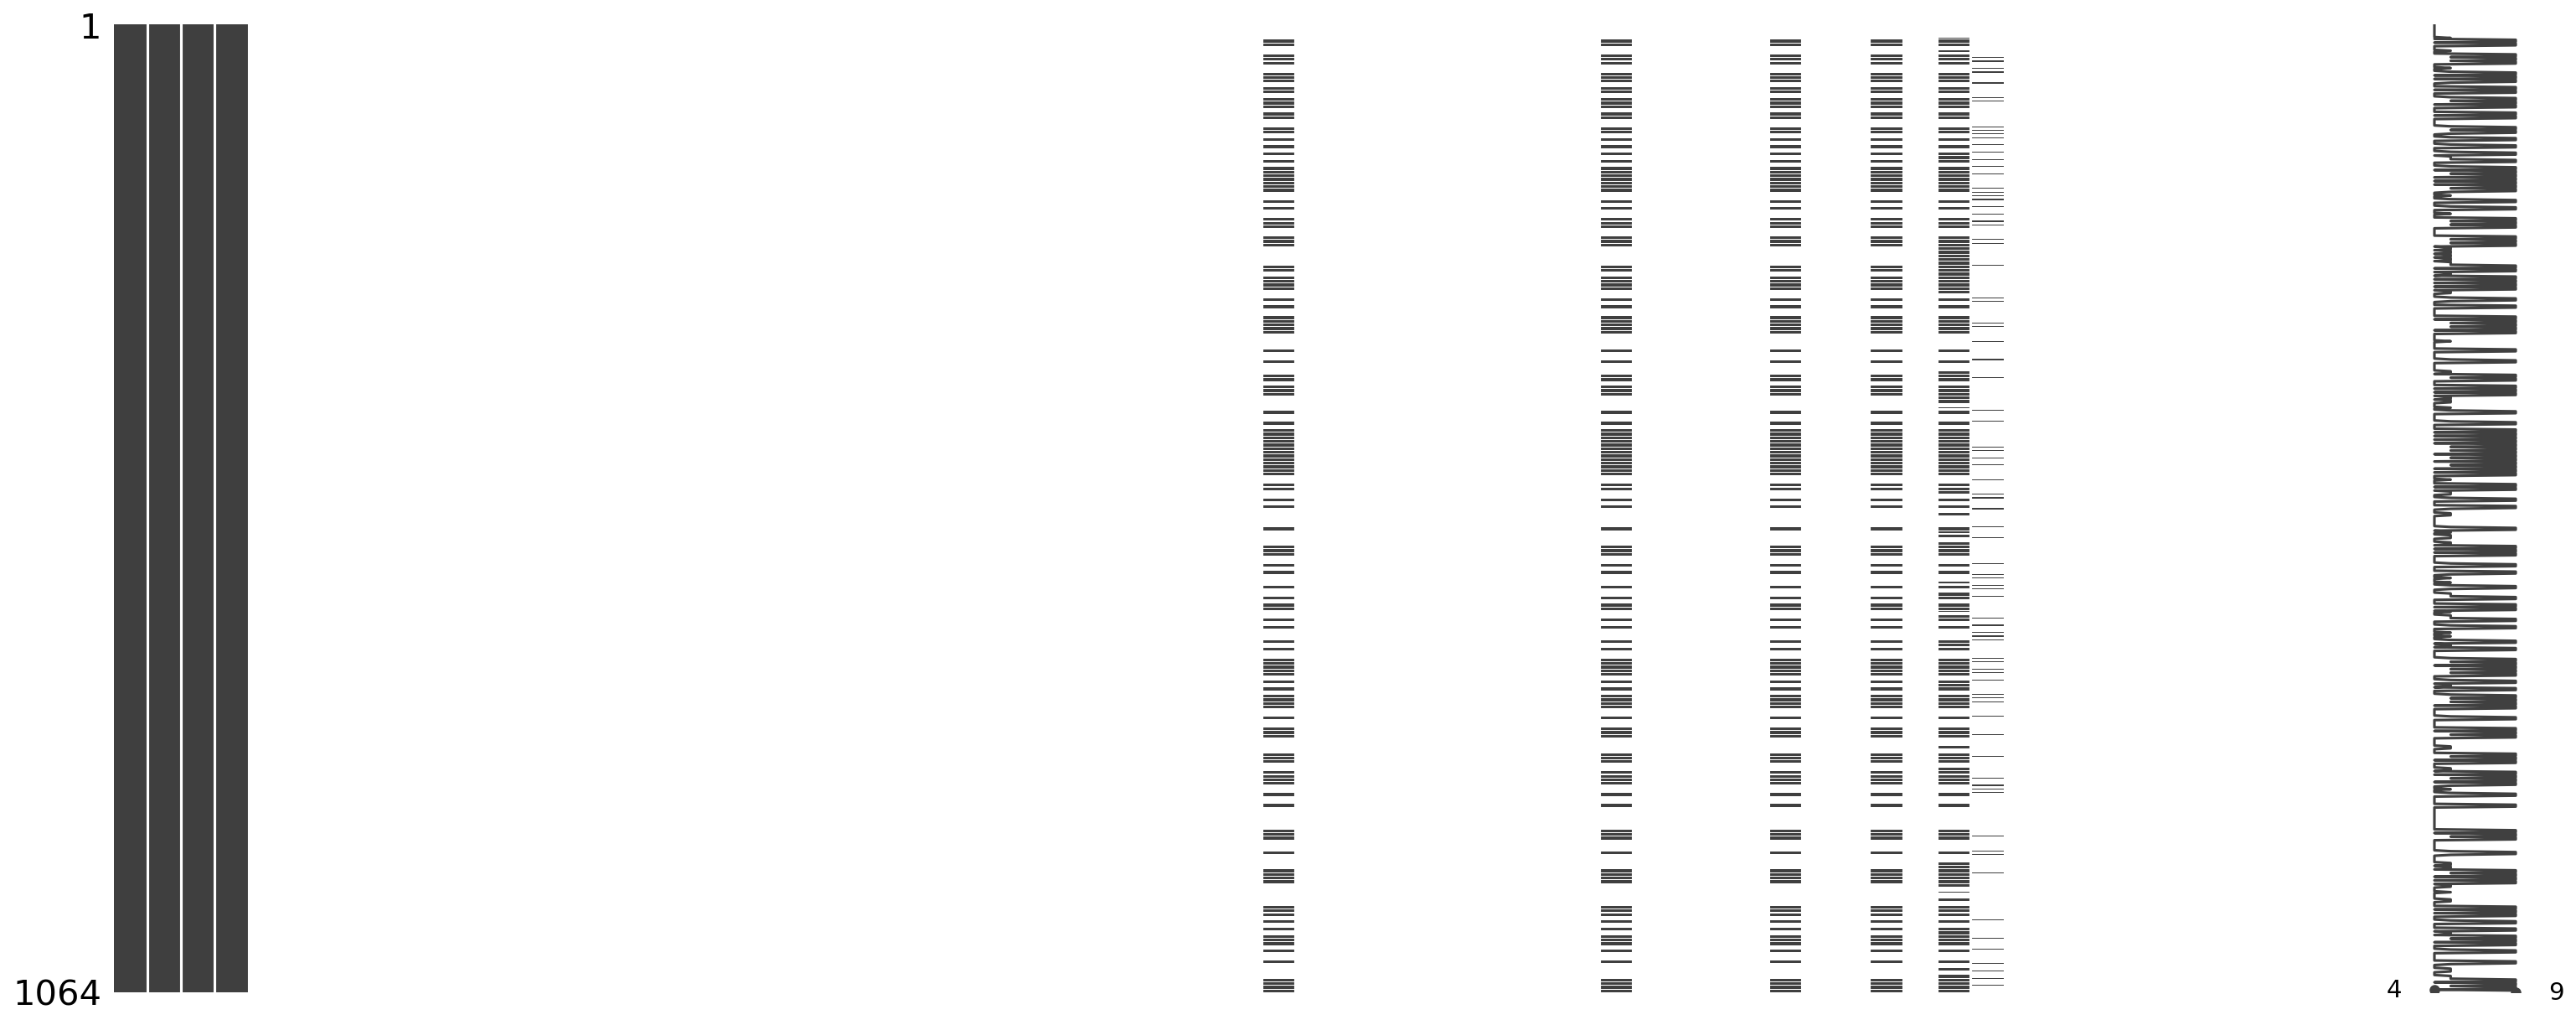

In [88]:
display(low_data_indicator3)
msno.matrix(df.loc[df['Indicator Name'].isin(low_data_indicator3.index.tolist())])

In [105]:
df_low_data_indicator3 = df.loc[df['Indicator Name'].isin(low_data_indicator3.index.tolist())]

# thresh = Require that many non-NA values
display(df_low_data_indicator3.dropna(axis=1, thresh=1))

Country Name Country Code  \
25                           Aruba          ABW   
26                           Aruba          ABW   
27                           Aruba          ABW   
32                           Aruba          ABW   
101    Africa Eastern and Southern          AFE   
...                            ...          ...   
20096                       Zambia          ZMB   
20165                     Zimbabwe          ZWE   
20166                     Zimbabwe          ZWE   
20167                     Zimbabwe          ZWE   
20172                     Zimbabwe          ZWE   

                                          Indicator Name     Indicator Code  \
25     Disaster risk reduction progress score (1-5 sc...     EN.CLC.DRSK.XQ   
26     SF6 gas emissions (thousand metric tons of CO2...  EN.ATM.SF6G.KT.CE   
27     PFC gas emissions (thousand metric tons of CO2...  EN.ATM.PFCG.KT.CE   
32     HFC gas emissions (thousand metric tons of CO2...  EN.ATM.HFCG.KT.CE   
101    Disaster risk reduction progress score (1-5 sc...     EN.CLC.DRSK.XQ   
...                                                  ...                ...   
20096  HFC gas emissions (thousand metric tons of CO2...  EN.ATM.HFCG.KT.CE   
20165  Disaster risk reduction progress score (1-5 sc...     EN.CLC.DRSK.XQ   
20166  SF6 gas emissions (thousand metric tons of CO2...  EN.ATM.SF6G.KT.CE   
20167  PFC gas emissions (thousand metric tons of CO2...  EN.ATM.PFCG.KT.CE   
20172  HFC gas emissions (thousand metric tons of CO2...  EN.ATM.HFCG.KT.CE   

       1990  2000  2005  2008  2010  2011  
25      NaN   NaN   NaN   NaN   NaN   NaN  
26      NaN   NaN   NaN   NaN   NaN   NaN  
27      NaN   NaN   NaN   NaN   NaN   NaN  
32      NaN   NaN   NaN   NaN   NaN   NaN  
101     NaN   NaN   NaN   NaN   NaN   NaN  
...     ...   ...   ...   ...   ...   ...  
20096   0.0   0.1   0.4   0.5   1.0   NaN  
20165   NaN   NaN   NaN   NaN   NaN   NaN  
20166   0.0   0.0   0.0   0.0   0.0   NaN  
20167   0.0   0.0   0.0   0.0   0.0   NaN  
20172   0.0   0.0   0.0   0.0   0.0   NaN  

[1064 rows x 10 columns]

In [91]:
interesting_data_indicator1 = getSingleCluster(cluster_Indicator_dbaKM, 19)
interesting_data_indicator2 = getSingleCluster(cluster_Indicator_dbaKM, 11)

cluster
Indicator Name                                       
Average precipitation in depth (mm per year)       18

<AxesSubplot:>

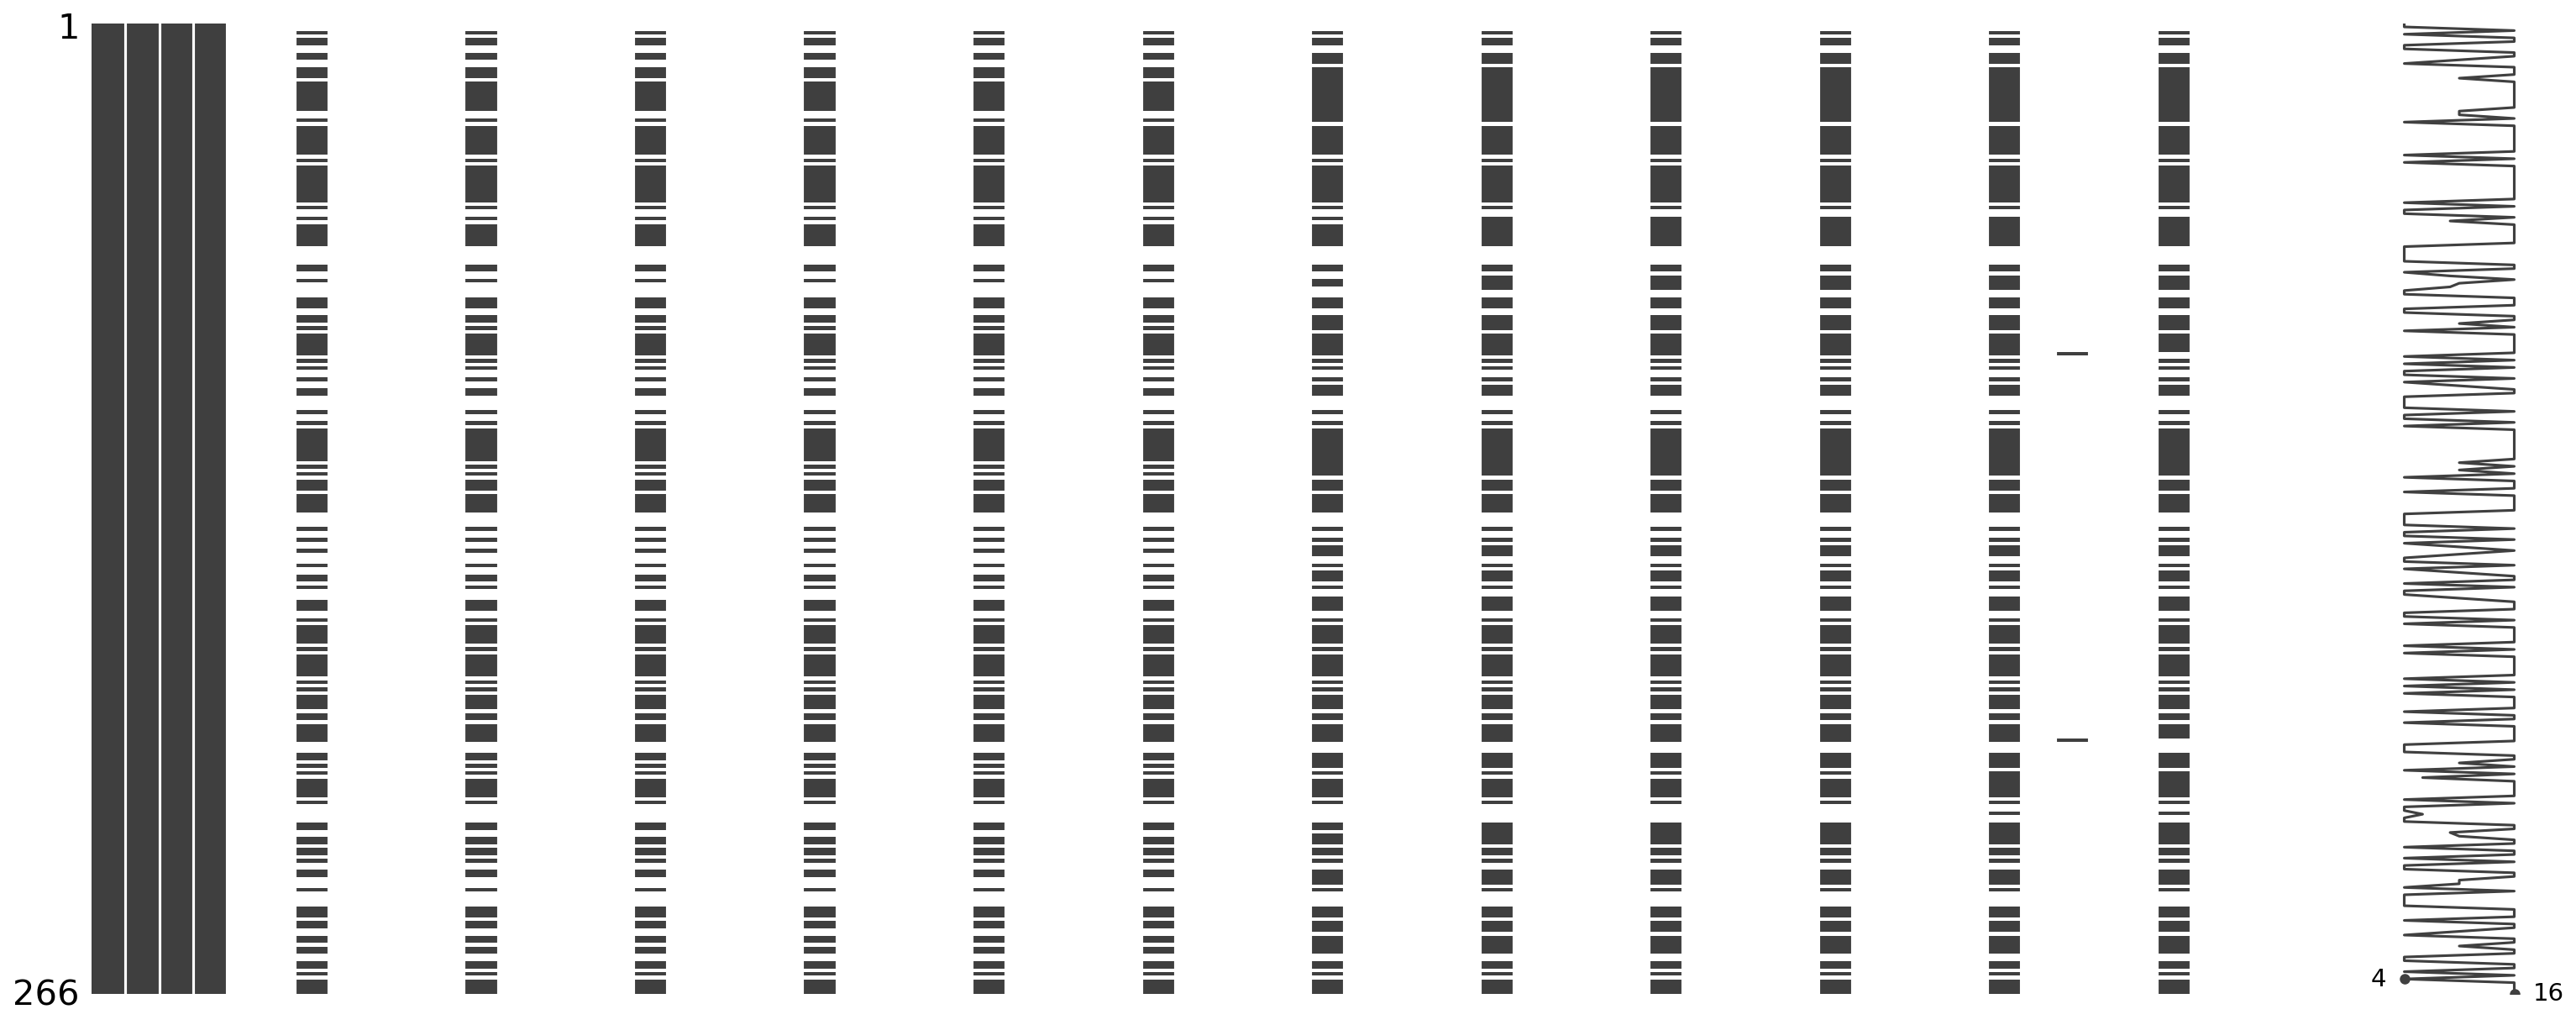

In [90]:
display(interesting_data_indicator1)
msno.matrix(df.loc[df['Indicator Name'].isin(interesting_data_indicator1.index.tolist())])

cluster
Indicator Name                                          
CO2 emissions (kg per 2015 US$ of GDP)                10
Mortality rate, under-5 (per 1,000 live births)       10

<AxesSubplot:>

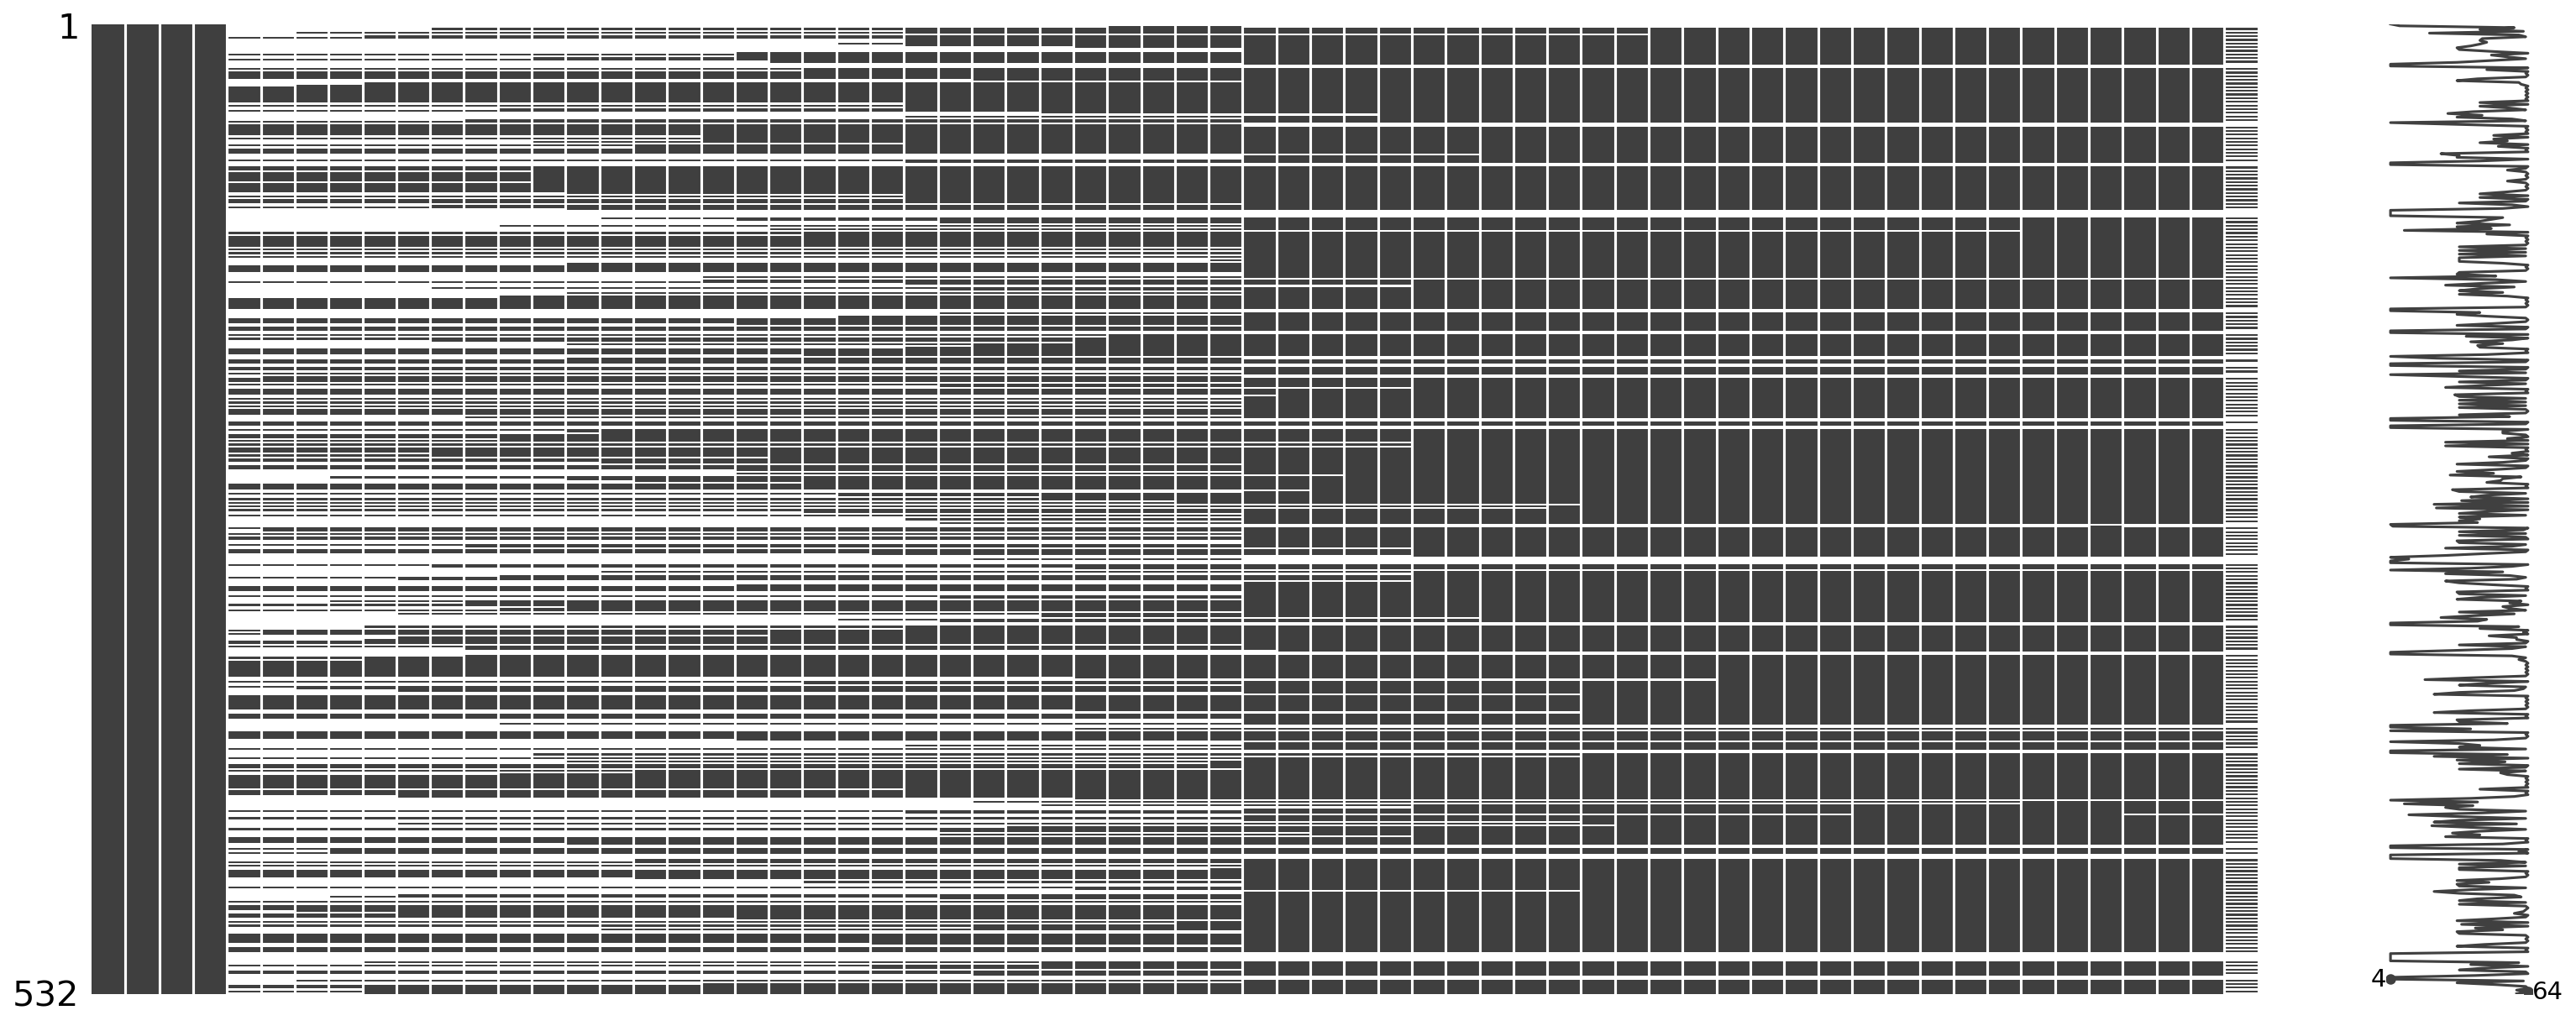

In [92]:
display(interesting_data_indicator2)
msno.matrix(df.loc[df['Indicator Name'].isin(interesting_data_indicator2.index.tolist())])

### Suggested indicator to drop due to insufficient data

## Group by Country

In [33]:
# Country column

df_country = df[listOfObjectColumnNames].iloc[: , 0:1]
df_country

Country Name
0            Aruba
1            Aruba
2            Aruba
3            Aruba
4            Aruba
...            ...
20211     Zimbabwe
20212     Zimbabwe
20213     Zimbabwe
20214     Zimbabwe
20215     Zimbabwe

[20216 rows x 1 columns]

In [34]:
# concat df_country and df_years back together

df_countryAndYears = pd.concat([df_country, df_years], axis=1)

# final preprocessed data

df_countryAndYears.tail()

Country Name  1960  1961  1962  1963  1964  1965  1966  1967  1968  ...  \
20211     Zimbabwe     0     0     0     0     0     0     0     0     0  ...   
20212     Zimbabwe     0     0     0     0     0     0     0     0     0  ...   
20213     Zimbabwe     0     1     1     1     1     1     1     1     1  ...   
20214     Zimbabwe     0     1     1     1     1     1     1     1     1  ...   
20215     Zimbabwe     0     1     1     1     1     1     1     1     1  ...   

       2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  
20211     0     0     0     0     0     0     0     0     0     0  
20212     0     0     0     0     0     0     0     0     0     0  
20213     1     1     1     1     1     1     1     1     0     0  
20214     1     1     1     1     1     1     1     1     0     0  
20215     1     1     1     1     1     1     1     1     0     0  

[5 rows x 62 columns]

In [35]:
# Make a new copy
df_groupBy_countryName = df_countryAndYears

# Then group by country
df_groupBy_countryName = df_groupBy_countryName.groupby(['Country Name']).sum()
df_groupBy_countryName.tail()

1960  1961  1962  1963  1964  1965  1966  1967  1968  \
Country Name                                                               
West Bank and Gaza     1     4     5     4     4     4     4     5     4   
World                 15    21    21    21    21    21    21    21    21   
Yemen, Rep.            8    14    16    15    15    15    15    16    15   
Zambia                 6    12    13    12    19    19    19    20    19   
Zimbabwe               5    11    12    11    18    19    19    20    19   

                    1969  ...  2011  2012  2013  2014  2015  2016  2017  2018  \
Country Name              ...                                                   
West Bank and Gaza     4  ...    21    21    20    21    19    20    15    15   
World                 21  ...    53    53    49    49    46    39    32    29   
Yemen, Rep.           15  ...    44    46    40    35    33    36    30    27   
Zambia                19  ...    43    46    40    35    35    33    31    29   
Zimbabwe              19  ...    46    50    43    40    39    34    33    29   

                    2019  2020  
Country Name                    
West Bank and Gaza    14    10  
World                 14     9  
Yemen, Rep.           12     9  
Zambia                14    10  
Zimbabwe              16    10  

[5 rows x 61 columns]

In [36]:
# drop index column first
df_check = df_groupBy_countryName.reset_index(drop=True)

# check value_counts() for all columns (should get only 0 - 76 )
df_check.apply(pd.Series.value_counts)

1960  1961  1962  1963  1964  1965  1966  1967  1968  1969  ...  2011  \
0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  ...   1.0   
1    3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
2    NaN   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0  ...   NaN   
3   38.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
4   13.0   1.0   NaN   1.0   1.0   1.0   1.0   NaN   1.0   1.0  ...   NaN   
..   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
60   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
61   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
62   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
63   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
64   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   

    2012  2013  2014  2015  2016  2017  2018  2019  2020  
0    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  
1    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   1.0  
4    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   2.0  
..   ...   ...   ...   ...   ...   ...   ...   ...   ...  
60   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
61   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
62   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
63   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
64   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[65 rows x 61 columns]

In [37]:
# copy the data
df_groupBy_countryName_normalized = df_groupBy_countryName.copy()
  
# apply normalization techniques
for column in df_groupBy_countryName_normalized.columns:
    df_groupBy_countryName_normalized[column] = df_groupBy_countryName_normalized[column]  / 76
      
# view normalized data
df_groupBy_countryName_normalized.tail()

1960      1961      1962      1963      1964  \
Country Name                                                           
West Bank and Gaza  0.013158  0.052632  0.065789  0.052632  0.052632   
World               0.197368  0.276316  0.276316  0.276316  0.276316   
Yemen, Rep.         0.105263  0.184211  0.210526  0.197368  0.197368   
Zambia              0.078947  0.157895  0.171053  0.157895  0.250000   
Zimbabwe            0.065789  0.144737  0.157895  0.144737  0.236842   

                        1965      1966      1967      1968      1969  ...  \
Country Name                                                          ...   
West Bank and Gaza  0.052632  0.052632  0.065789  0.052632  0.052632  ...   
World               0.276316  0.276316  0.276316  0.276316  0.276316  ...   
Yemen, Rep.         0.197368  0.197368  0.210526  0.197368  0.197368  ...   
Zambia              0.250000  0.250000  0.263158  0.250000  0.250000  ...   
Zimbabwe            0.250000  0.250000  0.263158  0.250000  0.250000  ...   

                        2011      2012      2013      2014      2015  \
Country Name                                                           
West Bank and Gaza  0.276316  0.276316  0.263158  0.276316  0.250000   
World               0.697368  0.697368  0.644737  0.644737  0.605263   
Yemen, Rep.         0.578947  0.605263  0.526316  0.460526  0.434211   
Zambia              0.565789  0.605263  0.526316  0.460526  0.460526   
Zimbabwe            0.605263  0.657895  0.565789  0.526316  0.513158   

                        2016      2017      2018      2019      2020  
Country Name                                                          
West Bank and Gaza  0.263158  0.197368  0.197368  0.184211  0.131579  
World               0.513158  0.421053  0.381579  0.184211  0.118421  
Yemen, Rep.         0.473684  0.394737  0.355263  0.157895  0.118421  
Zambia              0.434211  0.407895  0.381579  0.184211  0.131579  
Zimbabwe            0.447368  0.434211  0.381579  0.210526  0.131579  

[5 rows x 61 columns]

## Time series clustering based on country

In [38]:
# country train set

X_train_country = to_time_series_dataset(df_groupBy_countryName_normalized.copy())

Euclidean k-means
0.101 --> 0.077 --> 0.075 --> 0.075 --> 0.075 --> 0.075 --> 0.075 --> 0.075 --> 0.075 --> 0.075 --> 
Euclidean k-means Chart


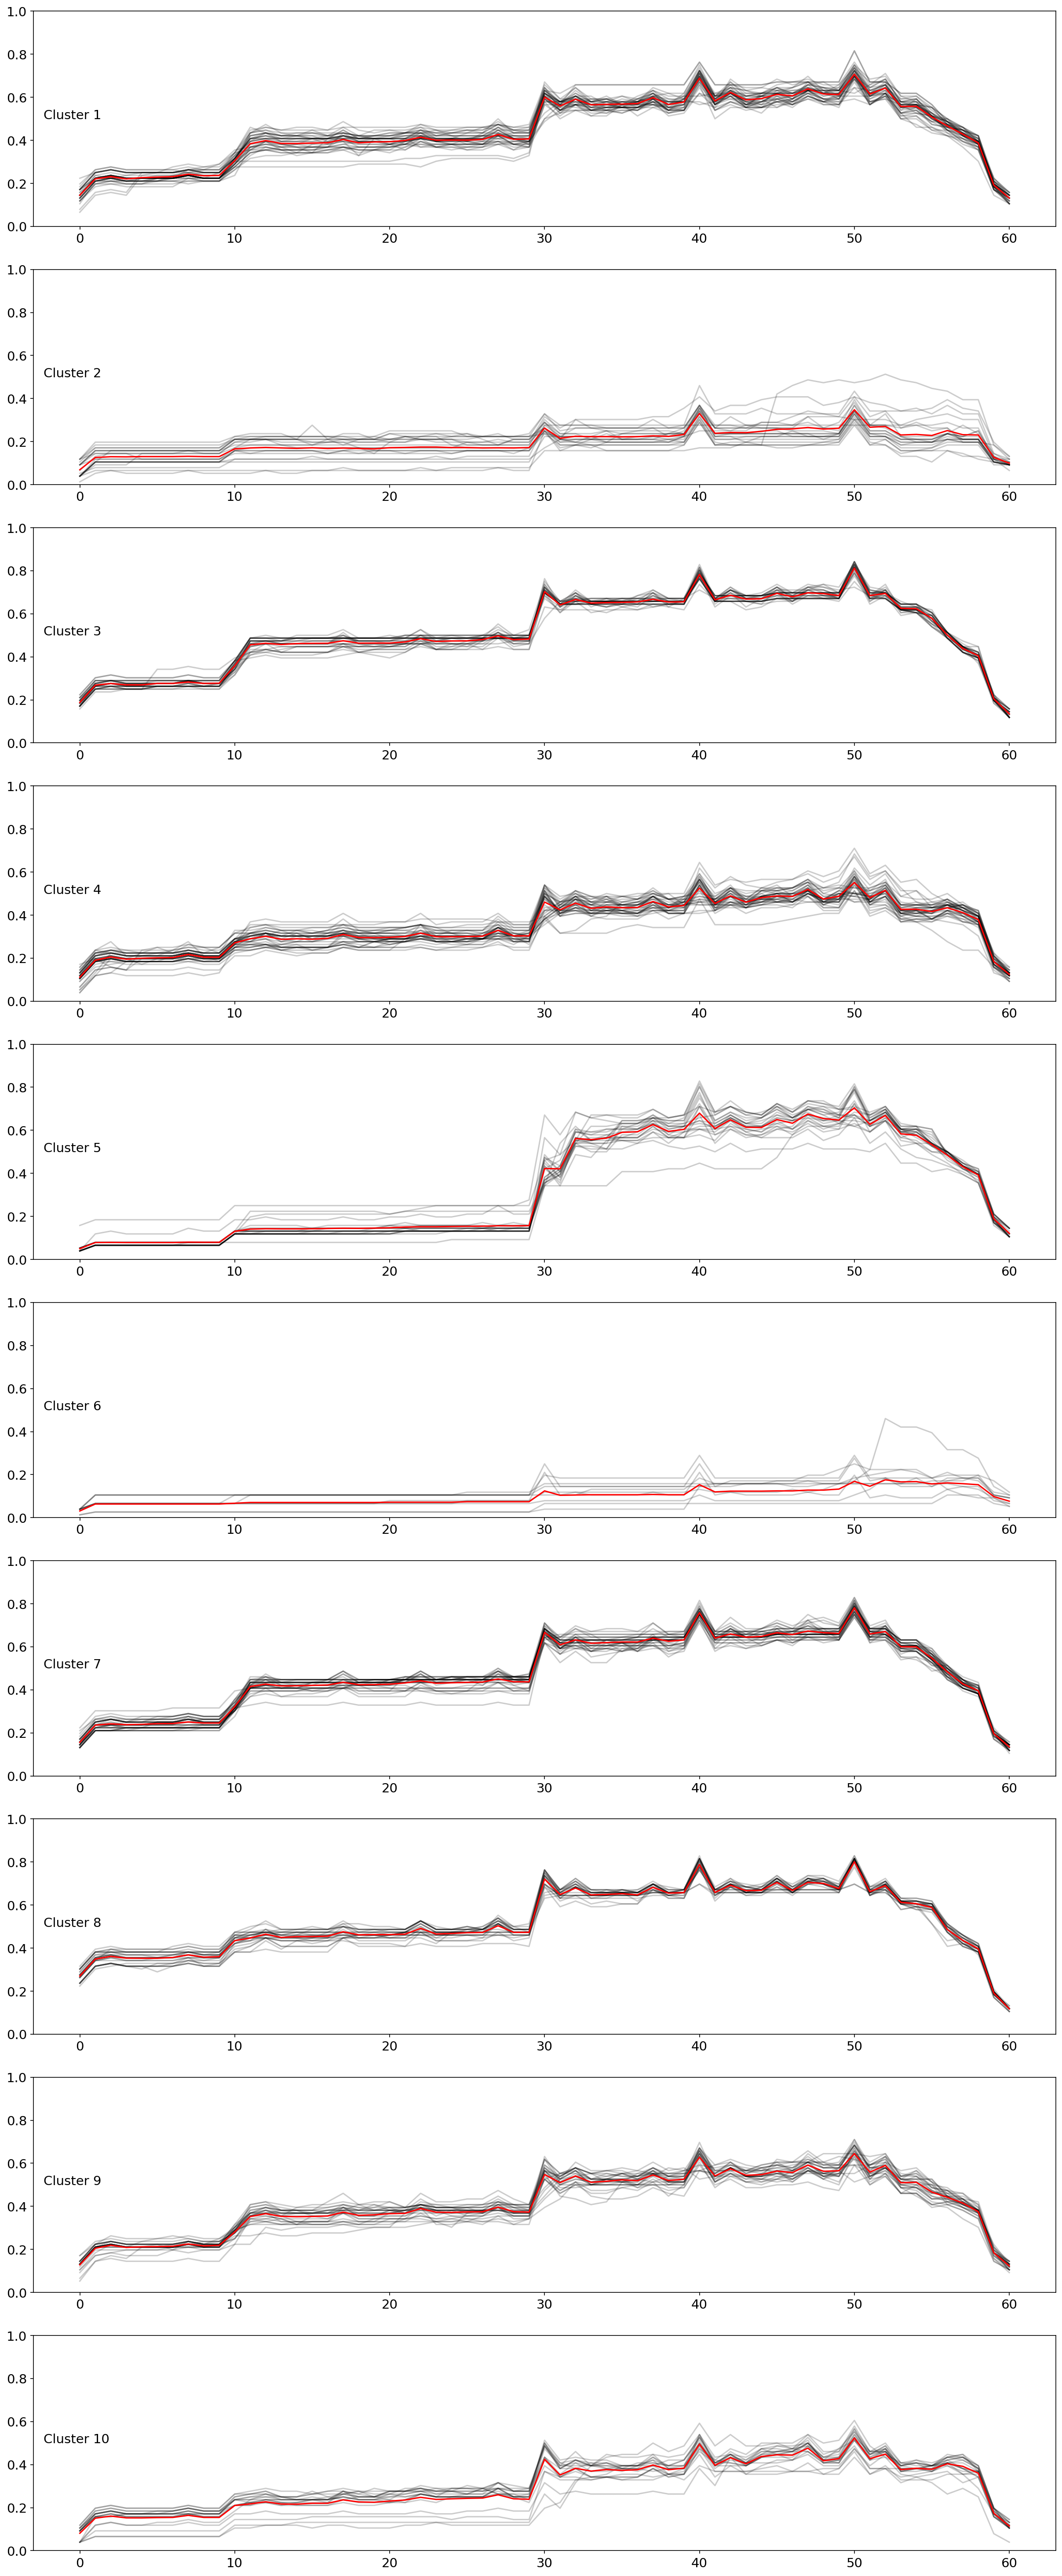

In [42]:
y_pred_country_euclideanKM = euclideanKMeans(10, seed, X_train_country)

In [44]:
cluster_country_euclideanKM = mergeClusterNames(y_pred_country_euclideanKM, df_groupBy_countryName)

### Suggested country to drop due to insufficient data

In [61]:
df_low_data_country = getSingleCluster(cluster_country_euclideanKM, 6)
low_data_country_index = df_low_data_country.index.tolist()
low_data_country_index

['Channel Islands',
 'Curacao',
 'Isle of Man',
 'Kosovo',
 'Monaco',
 'Northern Mariana Islands',
 'Not classified',
 'San Marino',
 'Sint Maarten (Dutch part)',
 'South Sudan',
 'St. Martin (French part)']

<AxesSubplot:>

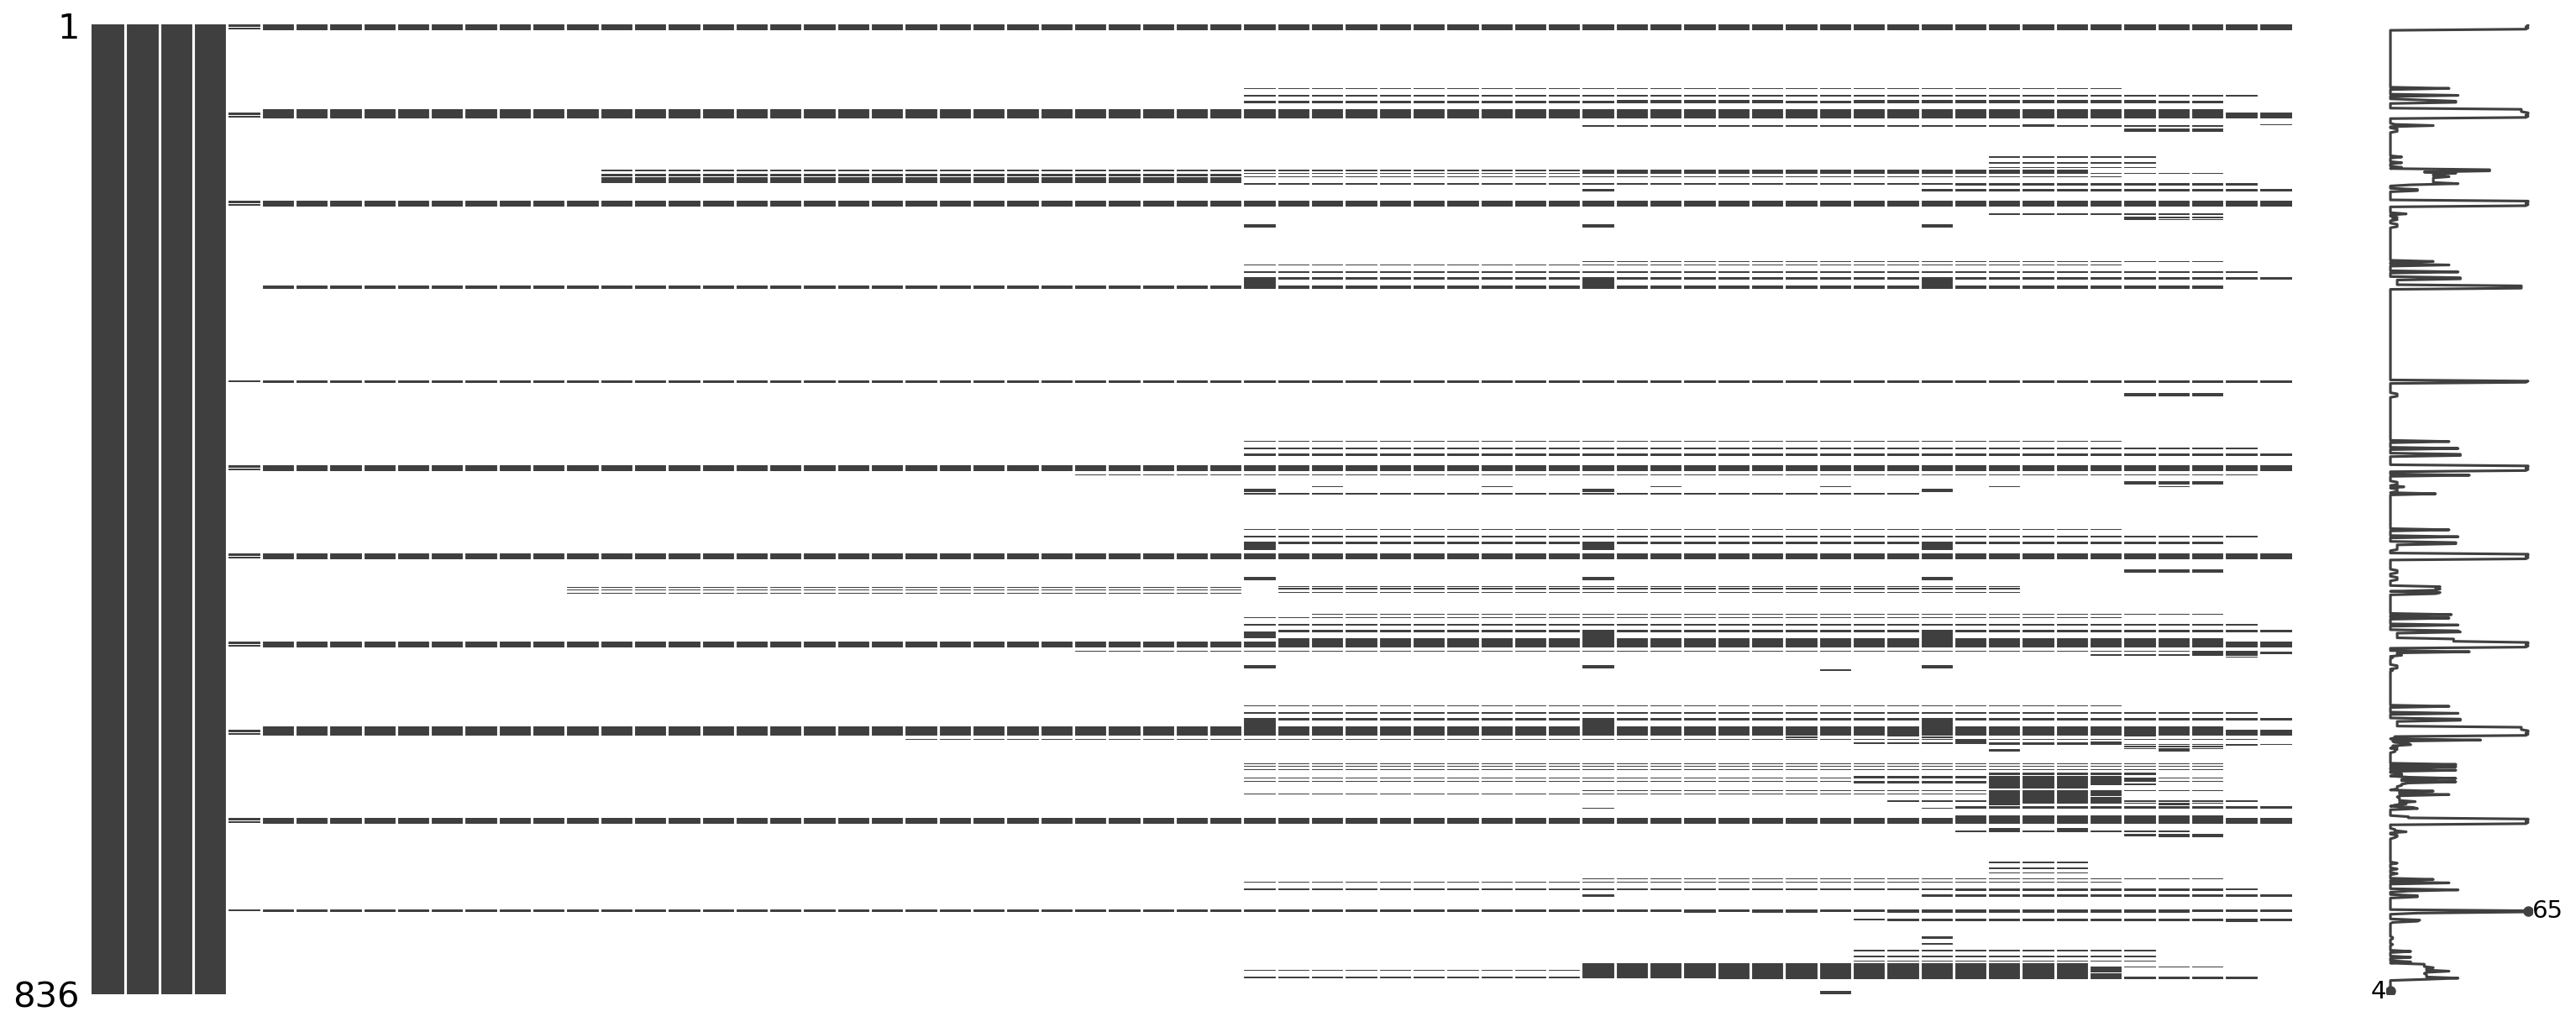

In [63]:
msno.matrix(df.loc[df['Country Name'].isin(low_data_country_index)])

In [64]:
df_high_data_country = getSingleCluster(cluster_country_euclideanKM, 7)
high_data_country_index = df_high_data_country.index.tolist()
high_data_country_index

['Algeria',
 'Arab World',
 'Bangladesh',
 'Bulgaria',
 'Central Europe and the Baltics',
 'Dominican Republic',
 'East Asia & Pacific (IDA & IBRD countries)',
 'East Asia & Pacific (excluding high income)',
 'Egypt, Arab Rep.',
 'Euro area',
 'Europe & Central Asia',
 'Fragile and conflict affected situations',
 'Germany',
 'IDA blend',
 'IDA only',
 'IDA total',
 'Iran, Islamic Rep.',
 'Israel',
 'Late-demographic dividend',
 'Least developed countries: UN classification',
 'Malaysia',
 'Middle East & North Africa',
 'Middle East & North Africa (IDA & IBRD countries)',
 'Middle East & North Africa (excluding high income)',
 'Morocco',
 'Nigeria',
 'Philippines',
 'Pre-demographic dividend',
 'Romania',
 'South Africa',
 'Sub-Saharan Africa',
 'Sub-Saharan Africa (IDA & IBRD countries)',
 'Sub-Saharan Africa (excluding high income)',
 'Thailand',
 'Tunisia',
 'Uruguay']

In [69]:
# since the number of country divided by cluster may not be the same,
# this part will address this issue and present msno based on same
# number of country

high_data_country_index_filtered = high_data_country_index[:len(low_data_country_index)]

cluster
Country Name                      
Channel Islands                  4
Curacao                          4
Isle of Man                      4
Kosovo                           4
Monaco                           4
Northern Mariana Islands         4
Not classified                   4
San Marino                       4
Sint Maarten (Dutch part)        4
South Sudan                      4
St. Martin (French part)         4

<AxesSubplot:>

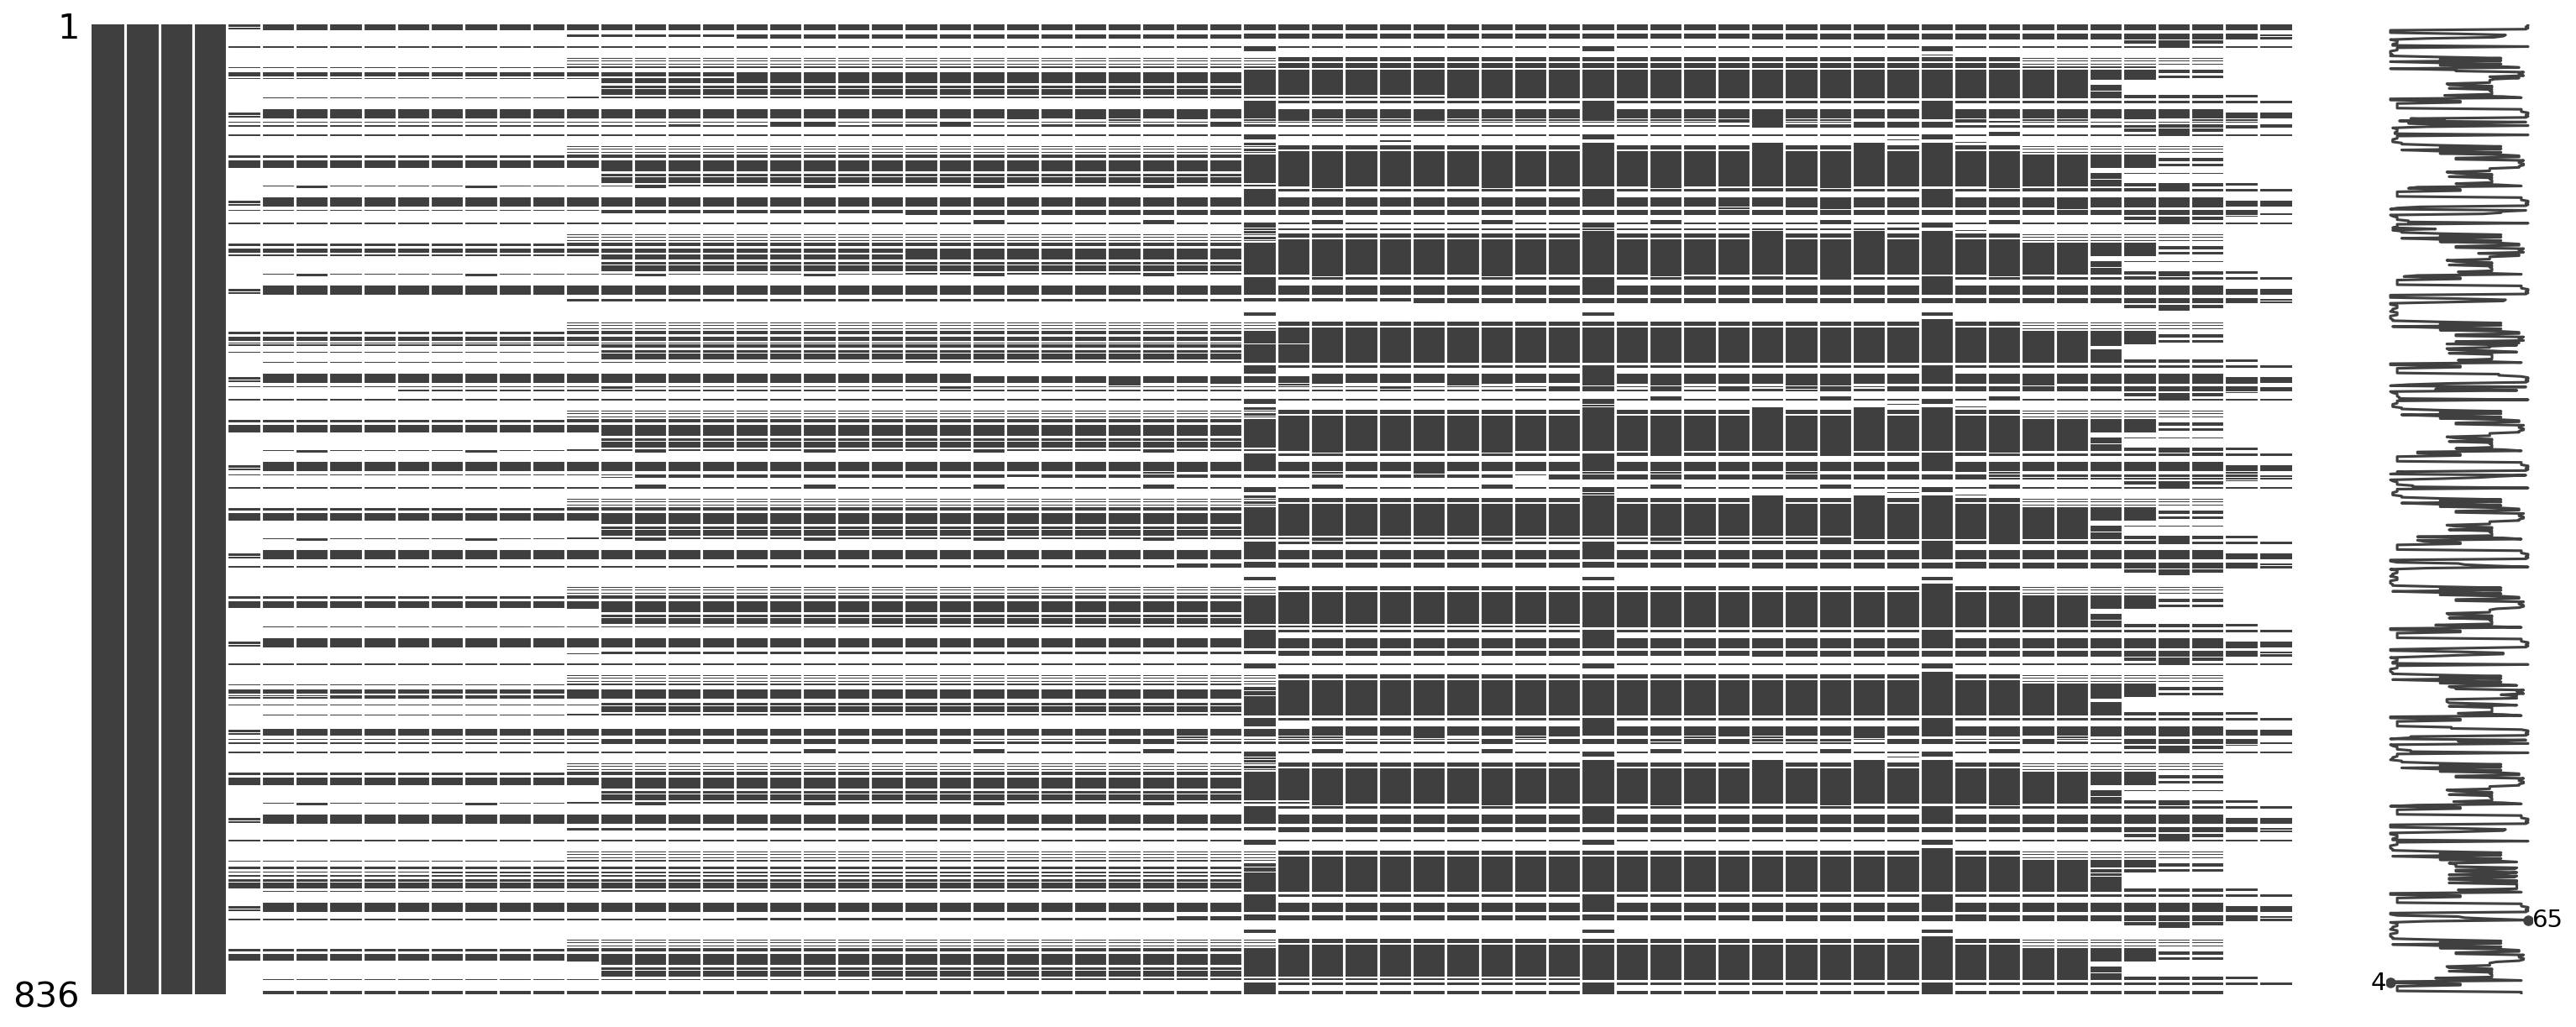

In [70]:
msno.matrix(df.loc[df['Country Name'].isin(high_data_country_index_filtered)])

## Conclusion

The final answer is not yet decided. But the indicator to select and country to drop is quite obvious after visualizing the missingo.